# Udemy Course Recommender
> Fetching Business course data from Udemy using official Udemy API 2.0, cleaning the data, exploring and building content-based course recommendation system

- toc: true
- badges: true
- comments: true
- categories: [Education, Scraping, Visualization, KMeans, PCA]
- author: "<a href='https://github.com/adrij/Udemy-recommender-system/tree/master/'>Adrienn Kitti Juhasz</a>"
- image:

Udemy.com is an online learning platform with more than 100.000 courses and over 30 million students all over the world. The platform offers courses in different categories e.g. Business, Design or Marketing. With all the available options it is very hard to choose the proper course, since everyone has a different taste. A recommender system helps students choose the next course, without spending hours reading different course descriptions. It does not only spare time for the user, but helps to find something interesting based on their previous course choices.

## Setup

In [1]:
!pip install squarify

In [2]:
#Import allrelevant libraries
import pandas as pd
import numpy as np

import scipy.stats as st

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import requests
import os

import requests
import ast
import pickle
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from operator import itemgetter
from collections import Counter
import matplotlib
import squarify
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import datetime
import scipy.stats as st
import ast
import re 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
#hide
#@markdown Utils
#get the data from the Udemy 
def get_data(url, username, pw):
    r = requests.get(url, auth=(username,pw))
    data_json=r.json()
    return data_json

#transform dataframe columns with dict/list values 
def transform_col(col, col_key=None):
	if col_key:
		return col.apply(lambda x: ast.literal_eval(x).get(col_key))
	else:
		return col.apply(lambda x: ast.literal_eval(x))

def get_float(text):
    r=re.search('\d+\.*\d*', text)
    if r:
        return float(r.group(0))
    else:
        return np.nan

def remove_tags(text):
    tag_re = re.compile(r'<[^>]+>')
    if text==text:
        return tag_re.sub('', text).replace('\n',' ').replace('\xa0',' ').replace('\t',' ')

#functions for stemming
def tokenize(text):
    stemmer=SnowballStemmer('english')
    return [stemmer.stem(word) for word in word_tokenize(text.lower())]

def tokenize_only(text):
    return [word for word in word_tokenize(text.lower())]

def combine_list(l):
    new_str=""
    for item in l:
        new_str=new_str+' '+str(item) 
    return new_str

def vocab_stem(text):
    stemmer=SnowballStemmer('english')
    total_stemmed = []
    total_tokenized = []
    for i in text:
        obj_stemmed = tokenize(i) 
        total_stemmed.extend(obj_stemmed) 
        obj_tokenized = tokenize_only(i)
        total_tokenized.extend(obj_tokenized)
    vocab_frame = pd.DataFrame({'words': total_tokenized}, index = total_stemmed)
    #print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
    return vocab_frame 

def drop_words(vocab_frame):
    vocab_frame=vocab_frame.reset_index()
    vocab_frame.columns = ['index','words']
    vocab_frame=vocab_frame.drop_duplicates(subset='index', keep='first').set_index('index')
    #print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
    return vocab_frame

def get_words_count(text, StopWords, vocab_frame):
    list_words=[tokenize(items) for items in text]

    word=[word for words in list_words for word in words if word not in StopWords]
    words_dict=Counter(word)
    if vocab_frame is None:
        return sorted(words_dict.items(), key=itemgetter(1), reverse=True)
    else:
        words_dict_new={}
        for k,v in words_dict.items():
            word_new=vocab_frame.loc[k].values.tolist()[0]
            words_dict_new[word_new]=v
        return sorted(words_dict_new.items(), key=itemgetter(1), reverse=True)

def top_words_graph(df_courses, attribute, comb_list, kind, StopWords, vocab_frame):
    for subcat in df_courses['primary_subcategory'].unique():
        temp=df_courses[df_courses['primary_subcategory']==subcat]
        if comb_list:
            text=temp[attribute].apply(combine_list).values
        else:
            text=temp[attribute].values
        top_words=get_words_count(text, StopWords, vocab_frame)[:25]
        plt.subplots(figsize=(10,8))
        if kind=='bar':
            plt.barh(range(len(top_words)), [val[1] for val in top_words], align='center')
            plt.yticks(range(len(top_words)), [val[0] for val in top_words])
            plt.xlabel("Number of occurences")    
        else:
            top_words=dict(top_words)
            wordcloud = WordCloud(width=900,height=500, margin=0).generate_from_frequencies(top_words)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
        plt.title(subcat)

def get_label(index, vocab_frame, word_features):
    return vocab_frame.loc[word_features[index]].values.tolist()[0]


def get_common_words(model, count_words):
    count_words_new=count_words*(-1)-1
    common_words = model.cluster_centers_.argsort()[:,-1:count_words_new:-1]
    return common_words

def print_common_words(common_words, word_features, vocab_frame, print_list=True):
    dict_cluster={}
    for num, centroid in enumerate(common_words):
        dict_cluster[num]=[get_label(word, vocab_frame, word_features) for word in centroid]
        if print_list:
            print(str(num) + ' : ' + ', '.join(dict_cluster[num]))
    if print_list==False:
        return dict_cluster
    
def plot_common_words(model, n_words, word_features, vocab_frame, df_courses, cluster_name):
    common_words=get_common_words(model, n_words)
    dict_cluster=print_common_words(common_words, word_features, vocab_frame, False)
    fig, ax=plt.subplots(figsize=(12,5))
    keys=df_courses[cluster_name].value_counts().sort_index().index
    values=df_courses[cluster_name].value_counts().sort_index().values
    colors=['b', 'g', 'y','r', 'k', 'grey', 'purple','orange', 'pink', 'brown']
    for j in range(len(keys)):
        ax.bar(keys[j], values[j], width=0.8, bottom=0.0, align='center', color=colors[j], alpha=0.4, label=dict_cluster[j]) 
    ax.set_xticks(np.arange(len(values)))
    ax.set_xticklabels(['cluster '+str(k) for k in keys])
    ax.set_ylabel('Number of courses')
    ax.set_title('Distribution of clusters with the top ' + str(n_words) + ' words')
    plt.legend(fontsize=13)
    
def squarify_words(common_words, word_features, vocab_frame):
    colormaps=['Purples', 'Blues', 'Greens', 'Oranges', 'Reds','Greys', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu',
           'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    for num, centroid in enumerate(common_words):
        sizes=np.arange(10,10+len(centroid))
        cmap_name=colormaps[num]
        cmap = plt.get_cmap(cmap_name)
        labels=[get_label(word, vocab_frame, word_features) for word in centroid]
        mini=min(sizes)
        maxi=max(sizes)
        norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
        colors = [cmap(norm(value)) for value in sizes]
        squarify.plot(sizes=sizes, label=labels,alpha=0.6, color=colors)
        plt.title("Most frequent words in cluster "+str(num))
        plt.show()

def heatmap_categories_cluster(cluster_name, df_courses, cmap ):
    clusters = df_courses.groupby([cluster_name, 'primary_subcategory']).size()
    fig, ax = plt.subplots(figsize = (30, 15))
    sns.heatmap(clusters.unstack(level = 'primary_subcategory'), ax = ax, cmap = cmap)
    ax.set_xlabel('primary_subcategory', fontdict = {'weight': 'bold', 'size': 24})
    ax.set_ylabel(cluster_name, fontdict = {'weight': 'bold', 'size': 24})
    for label in ax.get_xticklabels():
        label.set_size(16)
        label.set_weight("bold")
    for label in ax.get_yticklabels():
        label.set_size(16)
        label.set_weight("bold")   

def get_inertia(data, nClusterRange):
    inertias = np.zeros(len(nClusterRange))
    for i in range(len(nClusterRange)):
        model = KMeans(n_clusters=i+1, init='k-means++', random_state=1234).fit(data)
        inertias[i] = model.inertia_
    return inertias

def plot_inertia(kRange, inertia_Kmean):
    plt.figure(figsize=(10,8))
    plt.plot(kRange, inertia_Kmean, 'o-', color='seagreen', linewidth=3)
    #plt.plot([6], [testKmean[5]], 'o--', color='dimgray', linewidth=3)
    #plt.plot([1,6,11], [8520, 8170,7820], '--', color='k', linewidth=1)
    #plt.annotate("Let's try k=6", xy=(6, testKmean[5]), xytext=(6,7700),
             #size=14, weight='bold', color='dimgray',
             #arrowprops=dict(facecolor='dimgray', shrink=0.05))
    plt.xlabel('k [# of clusters]', size=18)
    plt.ylabel('Inertia', size=14)
    plt.title('Inertia vs KMean Parameter', size=14)

def print_titles_cluster(n_title, df_courses, cluster_name):
    for i in df_courses[cluster_name].unique():
        temp=df_courses[df_courses[cluster_name]==i]
        print(temp['published_title'].values[:n_title])

#functions for hierarchical clustering:
def get_linkage(X ):
    dist=pdist(X.todense(), metric='euclidean')
    z = linkage(dist, 'ward')
    return z

def plot_dendrogram(z, last_p_show, line_dist=None):
    # lastp is telling the algorithm to truncate using the number of clusters we set
    plt.figure(figsize=(20,10))
    plt.title('Dendrogram for attribute objectives')
    plt.xlabel('Data Index')
    plt.ylabel('Distance (ward)')
    dendrogram(z, orientation='top', leaf_rotation=90, p=last_p_show, truncate_mode='lastp', show_contracted=True);
    if line_dist!=None:
        plt.axhline(line_dist, color='k')

def plot_with_pca (X, labels, plot_n_sample):
    pca=PCA(n_components=2)
    X_2d=pca.fit_transform(X.todense())
    print('The explained variance through the first 2 principal comonent is {}.'
          . format(round(pca.explained_variance_ratio_.sum(),4)))
    df = pd.DataFrame(dict(x=X_2d[:,0], y=X_2d[:,1], label=labels)) 
    df_sample=df.sample(plot_n_sample)
    groups = df_sample.groupby('label')
    cluster_colors=['b', 'g', 'y','r', 'k', 'grey', 'purple','orange', 'pink', 'brown']
    fig, ax = plt.subplots(figsize=(17, 9)) 
    for name in np.arange(len(df_sample['label'].unique())):
        temp=df_sample[df_sample['label']==name]
        ax.plot(temp.x, temp.y, marker='o', linestyle='', ms=12, 
            label='cluster '+str(name), 
            color=cluster_colors[name], 
            mec='none', alpha=0.6)
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', bottom='off', top='off', labelbottom='off')
    ax.legend(numpoints=1) 
    plt.title('Courses with PCA decompostion')

#functions for the recommender system
def normalize_features(df):
    df_norm = df.copy()
    for col in df_norm.columns:
        df_norm[col] = StandardScaler().fit_transform(df_norm[col].values.reshape(-1, 1))
    return df_norm

def recommend_courses(id, n_courses, df_courses, df_norm):
    n_courses=n_courses+1
    id_=df_courses[df_courses['id']==id].index.values
    title=df_courses[df_courses['id']==id]['published_title']
    X = df_norm.values
    Y = df_norm.loc[id_].values.reshape(1, -1)
    cos_sim = cosine_similarity(X, Y)
    df_sorted=df_courses.copy()
    df_sorted['cosine_similarity'] = cos_sim
    df_sorted=df_sorted.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)

    return title, df_sorted.iloc[1:n_courses][['published_title', 'cosine_similarity']]

def recommend_for_user(user_name, n_courses, df_reviews, df_courses, df_norm):
    list_courses=df_reviews[df_reviews['user_name']==user_name]['id'].values
    len_courses=len(list_courses)
    index_courses=df_courses[df_courses['id'].isin(list_courses)].index
    for id in list_courses:
        title, df_recommend= recommend_courses(id, n_courses, df_courses, df_norm)
        print('The following courses are recommended after taking the course {} with the id {}:'
          .format(title.values[0],id))
        print(df_recommend)
        print()
    if len_courses>1:
        n_courses=n_courses+1
        df_temp=df_courses.copy()
        for i, id in enumerate(list_courses):
            id_=df_courses[df_courses['id']==id].index.values
            X = df_norm.values
            Y = df_norm.loc[id_].values.reshape(1, -1)
            cos_sim = cosine_similarity(X, Y)
            df_temp[i] = cos_sim
        temp_avg=df_temp.iloc[:,-len_courses:].mean(axis=1).values
        df_temp['avg_cos_sim']=temp_avg
        df_temp.drop(index=index_courses, inplace=True)
        df_temp=df_temp.sort_values('avg_cos_sim', ascending=False).reset_index(drop=True)
        print('The following courses are recommended after all taken courses:')
        print(df_temp.iloc[1:n_courses][['published_title', 'avg_cos_sim']])

## Data Import

### Import the courses

Import the Business courses from the Udemy API  - limit is 10.000 

> Tip: You can go to Udemy's site and request for *Affiliate API* access. For me, it took 7 hours to get approval.

In [ ]:
#hide-output
username='oZAbbHY1iopJmQlRBmUOvepJVAmEadBfLARYO42N'
pw = os.environ['udemy_client_secret']

list_json=[]
url='https://www.udemy.com/api-2.0/courses/?fields[course]=@all&page=1&category=Business'

global_counter = 0
local_counter = 0

while url!=None:
  if not os.path.exists(f"./courses_{global_counter+10}.txt"):
    try:
        local_counter+=1
        data_json=get_data(url, username, pw)
        url=data_json['next']
        list_json.extend(data_json['results'])
        if local_counter%10==0:
          local_counter = 0
          global_counter+=10
          with open(f"./courses_{global_counter}.txt", "wb") as fp:
            pickle.dump(list_json, fp)
          list_json = []
          print("Stored {} results!".format(global_counter))
    except:
        print(global_counter)
        continue
  else:
    global_counter+=10
    print("Stored {} results!".format(global_counter))

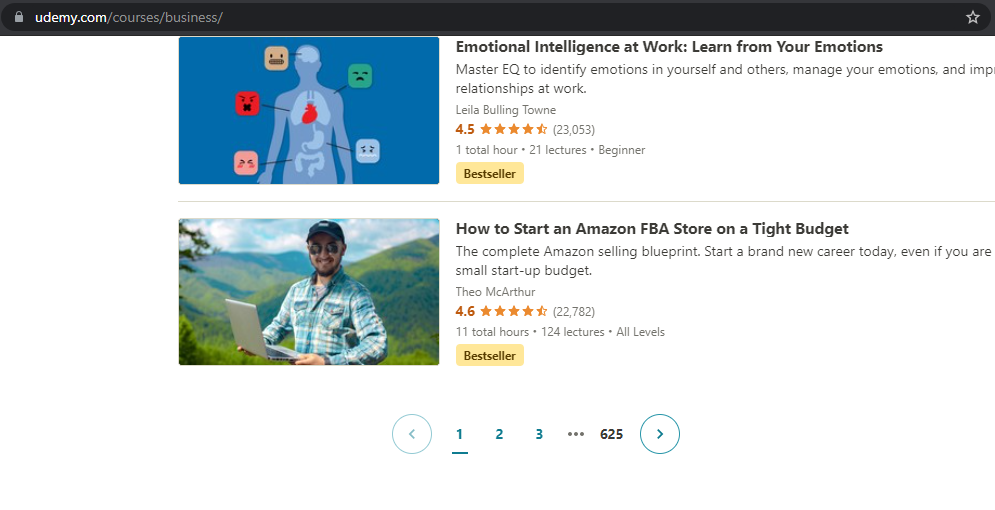

In [7]:
import glob
all_chunks = glob.glob("./*.txt")

list_json = []

for chunk in all_chunks:
  with open(chunk, "rb") as fp:
    list_json.extend(pickle.load(fp))

In [8]:
len(list_json)

11160

In [9]:
#Save the result in a dataframe and export to csv file
df_courses = pd.DataFrame.from_dict(list_json)
df_courses.to_csv('df_courses.csv')

In [10]:
df_courses.head()

_class      id  ... curriculum_items instructor_name
0  course  171838  ...               []            None
1  course  780078  ...               []            None
2  course  352440  ...               []            None
3  course  576504  ...               []            None
4  course   81534  ...               []            None

[5 rows x 150 columns]

In [11]:
df_courses.describe(include=['O'])

_class  ... instructor_name
count    11160  ...               0
unique       1  ...               0
top     course  ...             NaN
freq     11160  ...             NaN

[4 rows x 94 columns]

### Import the reviews

For these courses, I downloaded the available reviews. The maximum number of available reviews for a course is 10.000.

In [ ]:
#hide-output
local_counter = 0
global_counter = 0

for j, id_ in enumerate(df_courses['id'].values):    
    url="https://www.udemy.com/api-2.0/courses/{}/reviews/?page=1&page_size=100".format(id_)
    list_json_review=[]
    while url!=None:
        try:
          data_json=get_data(url, username, pw)
          url=data_json['next']
          list_json_review.extend(data_json['results'])
          if local_counter%100==0:
            local_counter = 0
            global_counter+=100
            with open(f"reviews_{global_counter}.txt", "wb") as fp:
              pickle.dump(list_json_review, fp)
            list_json_review = []
            print("Stored {} results!".format(global_counter))
        except:
        	continue
    if j==0:
        df_review= pd.DataFrame.from_dict(list_json_review)
        df_review['id']=id_
    else:
        df_review_unique = pd.DataFrame.from_dict(list_json_review)
        df_review_unique['id']=id_
        df_review = pd.concat([df_review, df_review_unique])

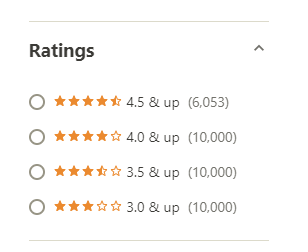

In [13]:
import glob
all_chunks = glob.glob("./Udemyreviews/*.txt")

list_json_review = []

for chunk in all_chunks:
  with open(chunk, "rb") as fp:
    list_json_review.extend(pickle.load(fp))

In [14]:
df_review = pd.DataFrame.from_dict(list_json_review)
df_review.to_csv('df_review.csv')

### Data Persistence

We will store these 2 datasets in parquet copressed format for efficient and quick loading in future.

In [ ]:
df_courses.to_parquet('udemy_courses.parquet.gzip', compression='gzip')
df_review.to_parquet('udemy_reviews.parquet.gzip', compression='gzip')

## Data Cleaning

Through the data cleaning process I did the following operations on the raw dataset:
1. import the raw data
2. transform the relevant columns
3. filter the dataset
4. keep only the relevant columns
5. drop the duplicates
6. treat the missing values
7. save the cleaned data

### Cleaning the course data

In [55]:
# 1. import the raw data
df_courses = pd.read_parquet("https://github.com/sparsh-ai/reco-data/raw/master/udemy/udemy_courses.parquet.gzip")

In [61]:
df_courses.shape

(11160, 150)

In [59]:
df_courses.head()

_class      id  ... curriculum_items instructor_name
0  course  171838  ...               []             NaN
1  course  780078  ...               []             NaN
2  course  352440  ...               []             NaN
3  course  576504  ...               []             NaN
4  course   81534  ...               []             NaN

[5 rows x 150 columns]

In [62]:
df_courses.columns.tolist()

['_class',
 'id',
 'title',
 'url',
 'is_paid',
 'price',
 'price_detail',
 'price_serve_tracking_id',
 'visible_instructors',
 'image_125_H',
 'image_240x135',
 'is_practice_test_course',
 'image_480x270',
 'published_title',
 'tracking_id',
 'description',
 'headline',
 'num_subscribers',
 'caption_locales',
 'discount',
 'discount_price',
 'avg_rating',
 'avg_rating_recent',
 'rating',
 'num_reviews',
 'num_reviews_recent',
 'rating_distribution',
 'favorite_time',
 'archive_time',
 'earnings',
 'completion_ratio',
 'is_wishlisted',
 'is_saved',
 'num_quizzes',
 'num_lectures',
 'num_published_lectures',
 'num_published_quizzes',
 'num_curriculum_items',
 'num_of_published_curriculum_objects',
 'num_cpe_credits',
 'is_private',
 'num_practice_tests',
 'num_published_practice_tests',
 'original_price_text',
 'quality_status',
 'status_label',
 'can_edit',
 'features',
 'gift_url',
 'num_invitation_requests',
 'notification_settings',
 'is_banned',
 'is_published',
 'intended_category

In [63]:
# 2. transform the relevant columns
df = df_courses.copy()
df['primary_category']=transform_col(df['primary_category'], 'title')
df['primary_subcategory']=transform_col(df['primary_subcategory'], 'title')
df['content_info']=df['content_info'].apply(get_float)
df['price']=df['price'].apply(get_float)
df['published_time']=pd.to_datetime(df['published_time']).dt.tz_convert(None)
df['published_since_month']=(datetime.datetime.now()-df['published_time']).apply(lambda x: int(x.days/30))
df['objectives']=transform_col(df['objectives'])
df['description'] = df['description'].fillna('description not available')
df['description_text']=df['description'].apply(remove_tags)

In [64]:
#transform the rating distribution 
rating_orig=[]
rating_rel=[]
for i, rating in enumerate(df['rating_distribution'].values):
    total=0
    temp={}
    temp_rel={}
    if rating:
        rating=ast.literal_eval(rating)
        for rating_j in rating:
            j=rating_j['rating']
            count_j=rating_j['count']
            total+=count_j
            temp[j]=count_j
        rating_orig.append(temp)
        if total>0:
            for k,v in temp.items():
                temp_rel[k]=round(v*1.0/total,3)
            rating_rel.append(temp_rel)
        else:
            rating_rel.append({1:0, 2:0, 3:0, 4:0, 5:0})
    else:
        rating_rel.append({1:0, 2:0, 3:0, 4:0, 5:0})
        rating_orig.append({1:0, 2:0, 3:0, 4:0, 5:0})
df_rating=pd.DataFrame(rating_rel)
df_rating.columns=['rating_1', 'rating_2', 'rating_3', 'rating_4','rating_5']
df=pd.concat([df, df_rating], axis=1)

In [65]:
df.shape

(11160, 157)

In [66]:
# 3. filter the dataset
df=df[(df['is_published']== True ) & (df['status_label']== 'Live')]
#drop the columns that are transformed or not relevant any more
df.drop(columns=['published_time','rating_distribution','status_label', 'is_published', 'rating', 'description' ], axis=1, inplace=True)

In [67]:
df.shape

(11160, 151)

In [68]:
# 4. keep the relevant columns
cols=['avg_rating', 'avg_rating_recent', 'description_text', 'has_certificate',  'is_paid',
      'id', 'instructional_level', 'is_enrollable_on_mobile', 'is_owned_by_instructor_team', 'is_practice_test_course', 
      'num_article_assets' , 'num_curriculum_items','num_lectures', 'num_practice_tests', 'num_quizzes',
      'num_subscribers', 'num_reviews', 'objectives', 'price','published_title', 'relevancy_score','rating_1', 
      'rating_2', 'rating_3', 'rating_4','rating_5', 'published_since_month', 'primary_category', 'primary_subcategory' ]
df=df[cols]

In [69]:
df.shape

(11160, 29)

In [70]:
# 5. drop the duplicates
df=df.drop_duplicates(subset='id', keep='first')

In [71]:
df.shape

(7568, 29)

In [73]:
df.isnull().sum()

avg_rating                        0
avg_rating_recent                 0
description_text                  0
has_certificate                   0
is_paid                           0
id                                0
instructional_level               1
is_enrollable_on_mobile           0
is_owned_by_instructor_team       0
is_practice_test_course           0
num_article_assets                0
num_curriculum_items              0
num_lectures                      0
num_practice_tests                0
num_quizzes                       0
num_subscribers                   0
num_reviews                       0
objectives                        0
price                           647
published_title                   0
relevancy_score                7568
rating_1                          0
rating_2                          0
rating_3                          0
rating_4                          0
rating_5                          0
published_since_month             0
primary_category            

In [74]:
# 6. check the missing values
#The free courses are labeled as free -> change price for these courses: 0 
df['price']=df['price'].fillna(0)

# drop relevancy_score
df = df.drop('relevancy_score', axis=1)

#drop the missings
df.dropna(how='any', inplace=True)

#in the objectives, there are empty lists 
index_to_drop=df[df['objectives'].apply(lambda x: x==list([]))].index
df.drop(index=index_to_drop, inplace=True)

In [75]:
df.shape

(7550, 28)

In [76]:
# 7. save the cleaned dataset
df.to_csv('df_courses.csv', sep=' ')

### Clean the review data

In [77]:
# 1. import the raw data
df_review_raw = pd.read_parquet("https://github.com/sparsh-ai/reco-data/raw/master/udemy/udemy_reviews.parquet.gzip")

In [79]:
df_review_raw.shape

(146955, 8)

In [78]:
df_review_raw.head()

_class  ...                                               user
0  course_review  ...  {'_class': 'user', 'title': 'Ryan McGovern', '...
1  course_review  ...  {'_class': 'user', 'title': 'Mohammad Rashad N...
2  course_review  ...  {'_class': 'user', 'title': 'Arth Patel', 'nam...
3  course_review  ...  {'_class': 'user', 'title': 'A Kowsar Parveen'...
4  course_review  ...  {'_class': 'user', 'title': 'A Nirmala', 'name...

[5 rows x 8 columns]

In [80]:
# 2. transform the relevant columns
df_review=df_review_raw.loc[:, ~df_review_raw.columns.str.match('Unnamed')]
df_review['user_name']=transform_col(df_review['user'], 'display_name')
df_review['user_title']=transform_col(df_review['user'], 'title')

In [81]:
# 3. filter the dataset from anonymized users (3 types)
df_review=df_review[~df_review['user_name'].isin(['Anonymized User', 'Private Udemy For Business User', 'Udemy User'])]

In [82]:
# 4. keep only the relevant columns
cols=['id', 'created', 'rating', 'user_name']
df_review=df_review[cols]

In [83]:
# 5. drop the duplicates
#the user names in the reviews data are not unique, it is impossible to build a recommender system based on the user ratings
df_review.drop_duplicates(inplace=True)

In [84]:
df_review.isnull().sum()

id           0
created      0
rating       0
user_name    0
dtype: int64

In [39]:
# 6. treat the missing values
#no missing values

In [85]:
# 7. save the cleaned data
df_review.to_csv('df_reviews.csv')

## EDA

Most important findings on the course dataset:
- there are courses with no reviews/ratings, but most of them are between rating 4 and 4.5
- The price ranges between 0 and 199 EUR
- There are some really popular courses with a lot of subscribers. The top 3 are:
        - machinelearning	with more than 300T subscribers
        - python-for-data-science-and-machine-learning-bootcamp with 192T subscribers
        - an-entire-mba-in-1-courseaward-winning-business-school-prof with 187T subscribers
- Most courses don't have any quizzes or practice tests
- The number of lectures mostly vary between 13 and 37 (IQR)
- The average age of a course is 26 months (since it was published). There are more recently published courses than older ones.
- The majority of the courses is for all levels. Only a few courses requires an advanced level.
- The courses are divided into 16 subcategories, whereas the two most significant are Finance and Entrepreneurship. 
        - Two subcategories have an average price higher than 100 dollars : The subcategory Data & analytics with 112, and Project Management with 104
        - The total earning on the courses is the highest in the subcategory for Data & Analytics and the second is in Entrepreneurship.
        - The total number of subscribers are the highest in the category of Entrepreneurship (1.) and in Data & Analytics (2.)
        - There is not much difference between the average ratings of the courses in each subcategory. The highest average ratings are in the subcategories Media and Communications. 
- I investigated the top words in each subcategories in the attributes objectives and description separately. E.g. in the subcategory Data& Analytics, the top 5 words are:
    - data, use, model, understand, create

After the univariate analysis I also executed multivariate analysis:
- There is a positive correlation between the number of reviews/number of subscribers and the average rating - students normally give good ratings for courses they liked
- As expected, there is a positive correlation between number of subscribers and number of reviews
- There is also a positive correlation between published since and the average rating -> older courses have better ratings. This seems logic, since I would expect that courses which aren't popular won't stay long on the sortiment
- The price doesn't have an effect on the average ratings or on the number of subsribers

Most important findings on the reviews dataset: 
- The users are unfortunately not unique. Because if this reason, it is not possible to build a recommender system on the user ratings. 
- - Most users (more than 600.000) gave only one review, but there are couple user_names, who have plenty of reviews: the most common username is David with more than 400 reviews.
- Most courses have very few reviews



In [42]:
import pandas as pd
import numpy as np
import ast
import scipy.stats as st

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#for the text attributes
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from operator import itemgetter
from nltk.stem import SnowballStemmer

### EDA of the course dataset

In [87]:
df_courses = pd.read_csv('df_courses.csv', index_col=0, sep=' ', converters={"objectives": ast.literal_eval})
df_courses.head()

avg_rating  ...                primary_subcategory
0    4.483728  ...                      Communication
1    4.452830  ...                      Communication
2    4.509386  ...                 Project Management
3    4.117857  ...  Business Analytics & Intelligence
4    4.490196  ...                         E-Commerce

[5 rows x 28 columns]

#### Numerical columns

In [88]:
df_courses.describe()

avg_rating  avg_rating_recent  ...     rating_5  published_since_month
count  7550.000000        7550.000000  ...  7550.000000            7550.000000
mean      3.722400           3.708659  ...     0.414574              31.973907
std       1.458542           1.459689  ...     0.262966              26.615780
min       0.000000           0.000000  ...     0.000000               0.000000
25%       3.750000           3.746468  ...     0.267000               9.000000
50%       4.250000           4.226052  ...     0.429000              25.000000
75%       4.500000           4.507347  ...     0.570000              49.000000
max       5.000000           5.000000  ...     1.000000             121.000000

[8 rows x 17 columns]

There are around 900 courses with no reviews/ratings, but most of the ratings are between rating 4 and 4.5.

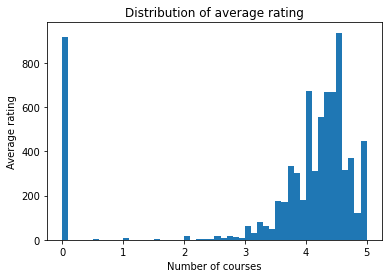

In [90]:
plt.hist(df_courses['avg_rating'], bins=50)
plt.xlabel('Number of courses')
plt.ylabel('Average rating')
plt.title('Distribution of average rating')
plt.savefig('avg_rating.png')

The price ranges between 0 and 199 EUR. Most courses cost eiter 19.99 or 199.99 $.

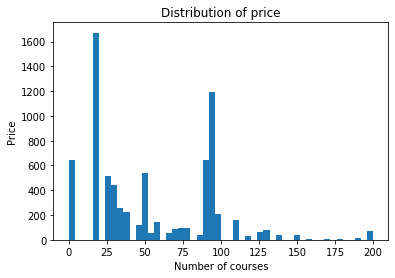

In [92]:
plt.hist(df_courses['price'], bins=50)
plt.xlabel('Number of courses')
plt.ylabel('Price')
plt.title('Distribution of price')
plt.savefig('price.png')

I checked which courses are most visited. Courses with the top 10 most subscribers can be seen below:

In [93]:
#most popular courses
top10_courses= df_courses.sort_values('num_subscribers', ascending=False)[['published_title', 'num_subscribers']].head(10)
for i, row in top10_courses.iterrows():
    print('The course {} has {} subscribers.'.format(row['published_title'],row['num_subscribers']))

The course an-entire-mba-in-1-courseaward-winning-business-school-prof has 407741 subscribers.
The course the-complete-sql-masterclass-for-data-analytics has 325874 subscribers.
The course how-to-build-an-online-business-a-complete-business-plan has 221348 subscribers.
The course pmp-pmbok6-35-pdus has 206294 subscribers.
The course secret-sauce-of-great-writing has 187239 subscribers.
The course powerbi-complete-introduction has 171089 subscribers.
The course the-business-intelligence-analyst-course-2018 has 153522 subscribers.
The course microsoft-power-bi-up-running-with-power-bi-desktop has 140450 subscribers.
The course agile-crash-course has 139350 subscribers.
The course online-business-selling-simple-products-amazon has 136379 subscribers.


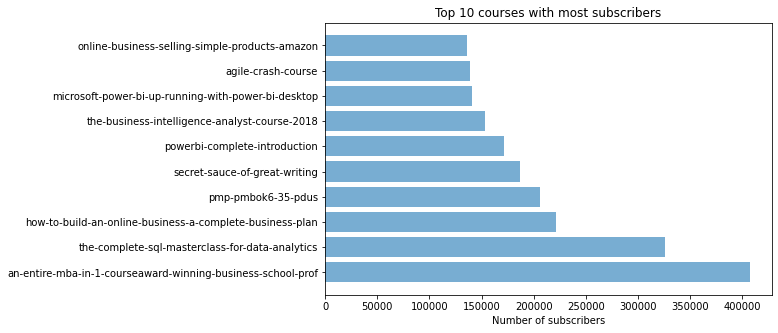

In [95]:
fig, ax= plt.subplots(figsize=(8,5))
ax.barh(np.arange(len(top10_courses)), top10_courses['num_subscribers'], alpha=0.6)
plt.yticks(np.arange(len(top10_courses)), top10_courses['published_title'])
plt.title('Top 10 courses with most subscribers')
ax.set_xlabel('Number of subscribers')
plt.savefig('top10courses.png')

I plotted a histogram and a boxplot from each numerical attribute. Some of the features has outliers, and the distribution is skewed.

Number of 0 values of attribute avg_rating is 917.
Number of 0 values of attribute avg_rating_recent is 917.
Number of 0 values of attribute num_article_assets is 4866.
Number of 0 values of attribute num_curriculum_items is 0.
Number of 0 values of attribute num_lectures is 268.
Number of 0 values of attribute num_practice_tests is 7118.
Number of 0 values of attribute num_quizzes is 5098.
Number of 0 values of attribute num_subscribers is 356.
Number of 0 values of attribute num_reviews is 917.
Number of 0 values of attribute price is 642.
Number of 0 values of attribute published_since_month is 150.
Number of 0 values of attribute rating_1 is 4091.
Number of 0 values of attribute rating_2 is 3680.
Number of 0 values of attribute rating_3 is 2260.
Number of 0 values of attribute rating_4 is 1706.
Number of 0 values of attribute rating_5 is 1312.


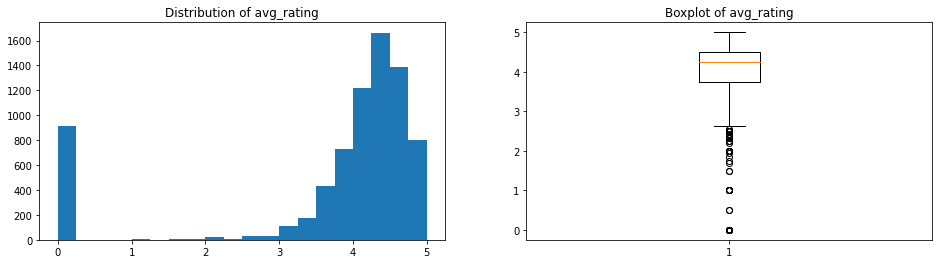

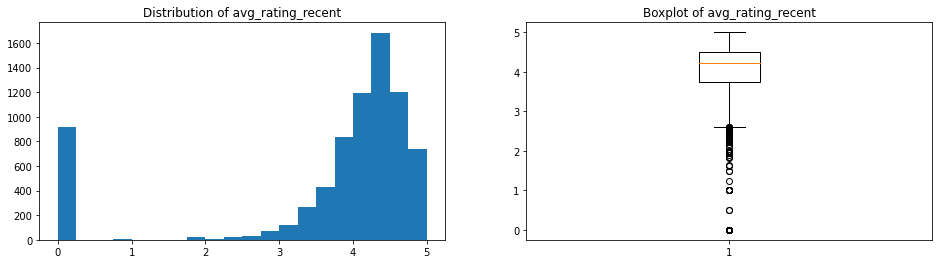

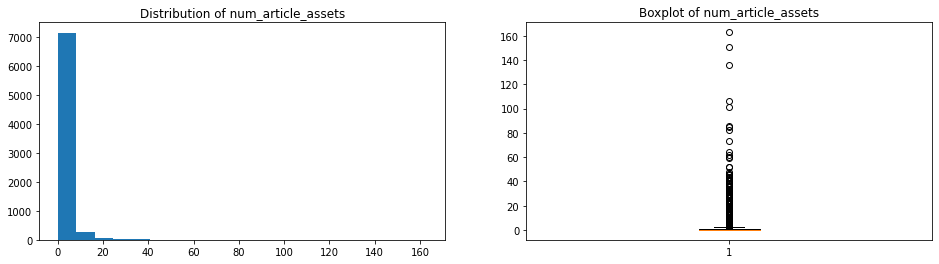

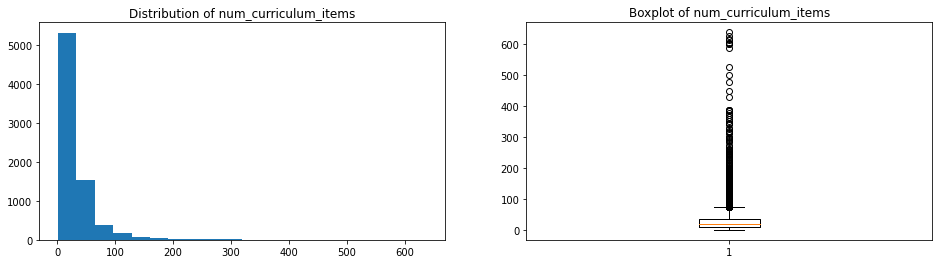

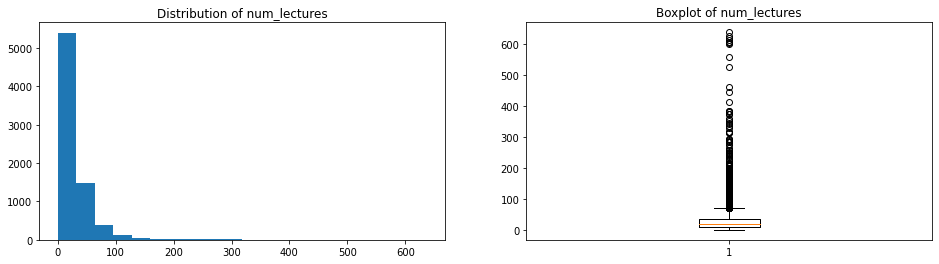

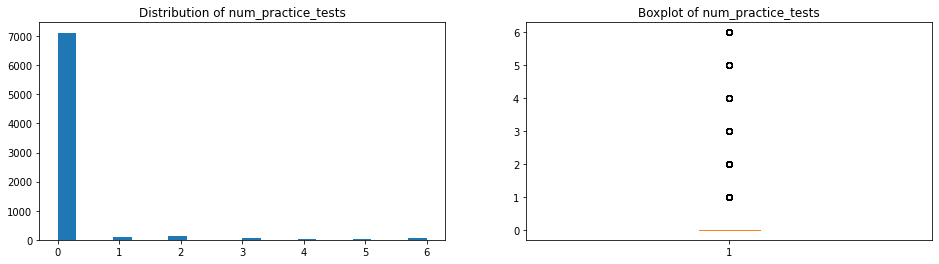

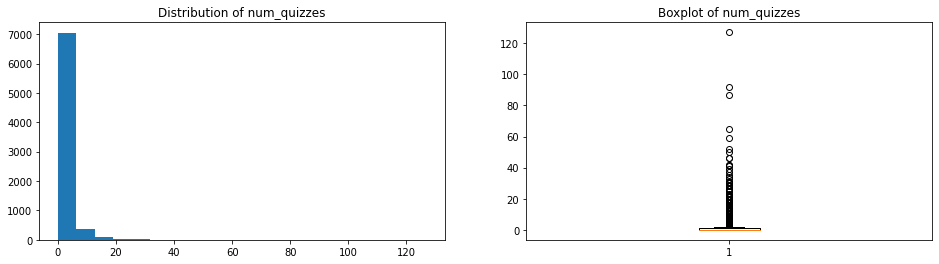

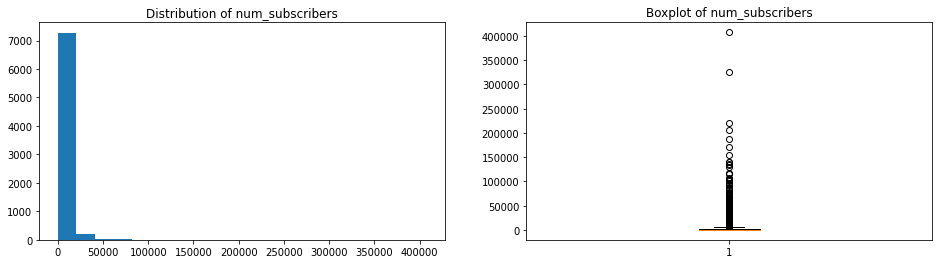

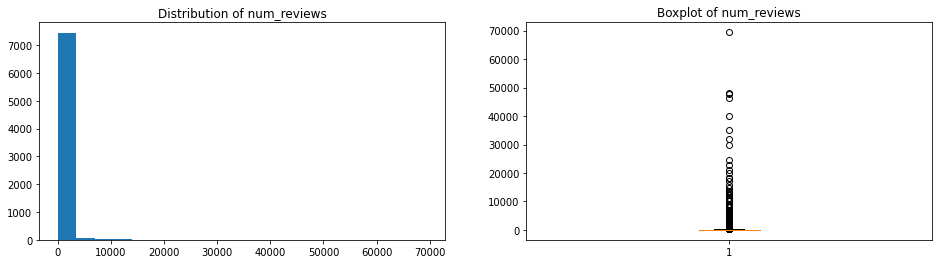

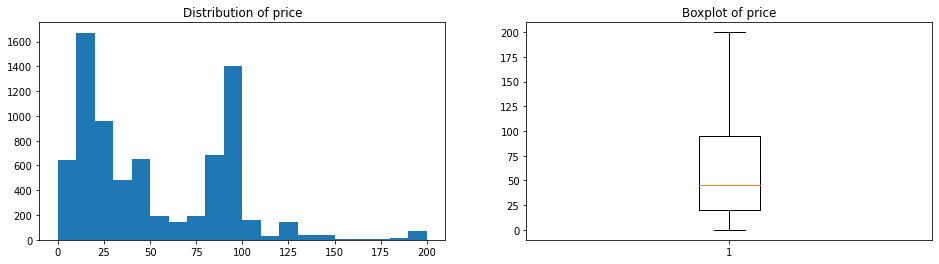

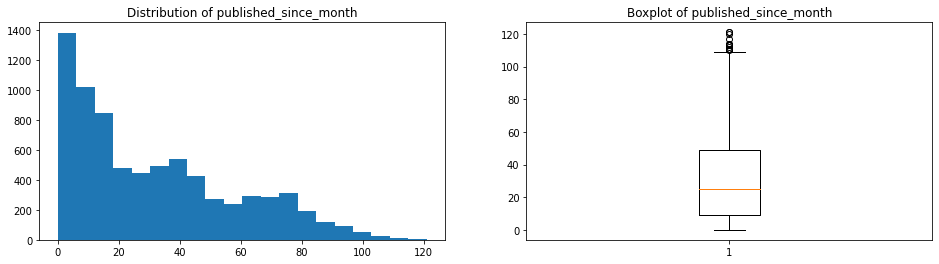

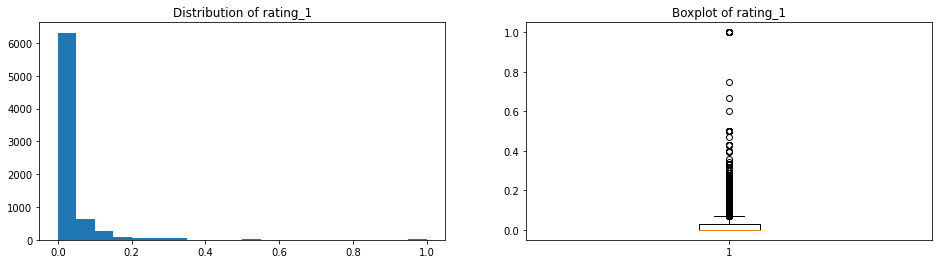

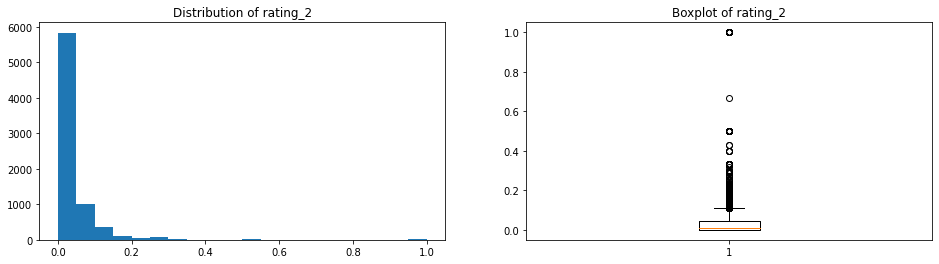

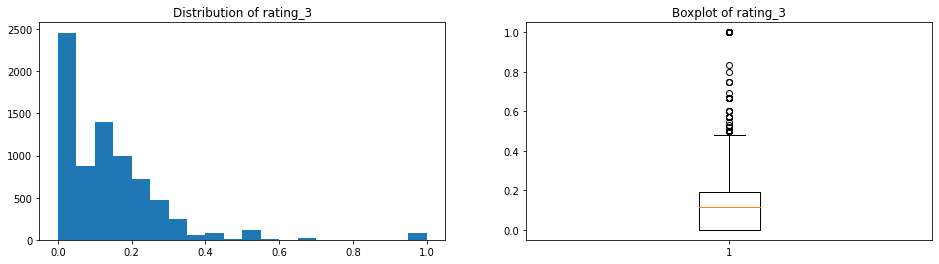

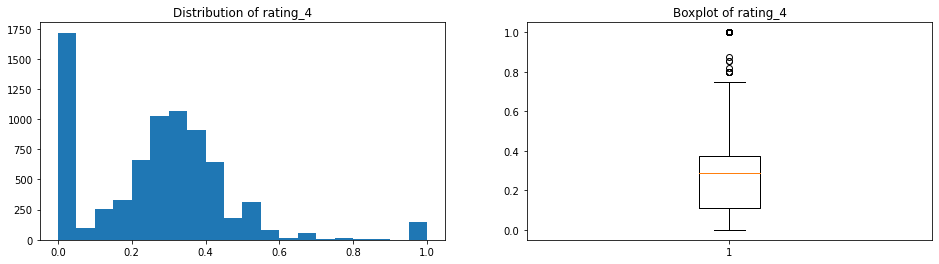

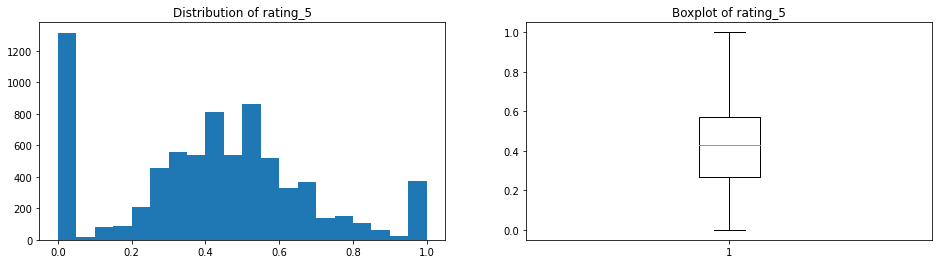

In [97]:
var_num=['avg_rating', 'avg_rating_recent','num_article_assets' , 'num_curriculum_items',
         'num_lectures', 'num_practice_tests', 'num_quizzes','num_subscribers', 'num_reviews', 'price', 
         'published_since_month', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']

for col in var_num:
    fig, ax= plt.subplots(1,2,figsize=(16,4))
    ax[0].hist(df_courses[col], bins=20)
    ax[1].boxplot(df_courses[col])
    ax[0].set_title('Distribution of '+ str(col))
    ax[1].set_title('Boxplot of '+ str(col))
    print('Number of 0 values of attribute {} is {}.'.format(col, len(df_courses[df_courses[col]==0])))

I defined all data points, whose distance from the mean is more than 3*standard deviation, as outliers. I checked the distribution without these outliers. I didn't excluded these outliers from the data, I only excluded them to have a better understanding of the distribution of the features.

Number of dropped values of attribute avg_rating is 0.
Number of dropped values of attribute avg_rating_recent is 0.
Number of dropped values of attribute num_article_assets is 111.
Number of dropped values of attribute num_curriculum_items is 113.
Number of dropped values of attribute num_lectures is 115.
Number of dropped values of attribute num_practice_tests is 185.
Number of dropped values of attribute num_quizzes is 102.
Number of dropped values of attribute num_subscribers is 90.
Number of dropped values of attribute num_reviews is 59.
Number of dropped values of attribute price is 90.
Number of dropped values of attribute published_since_month is 11.


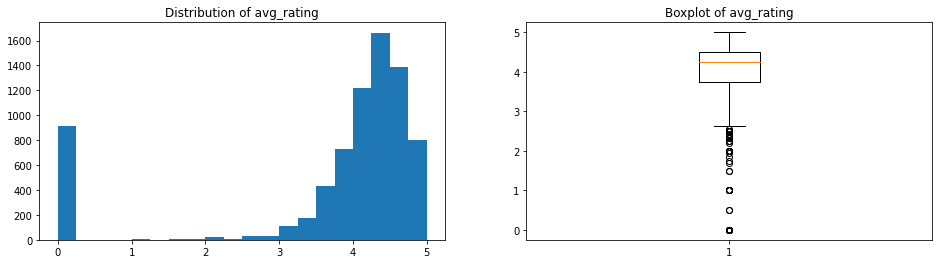

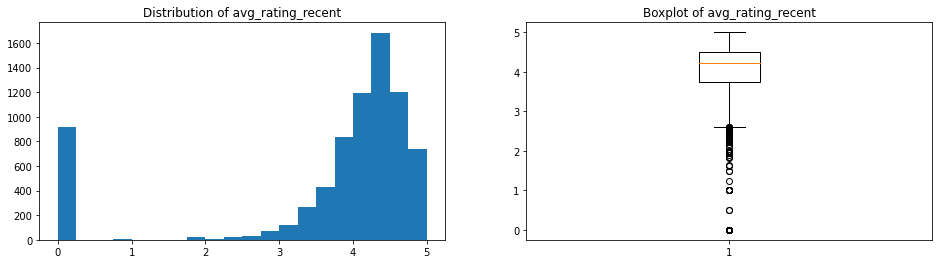

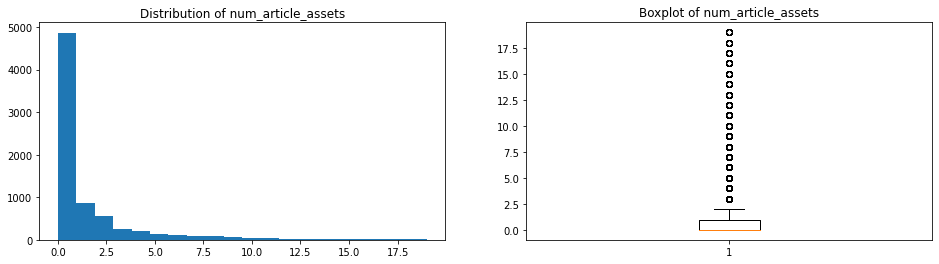

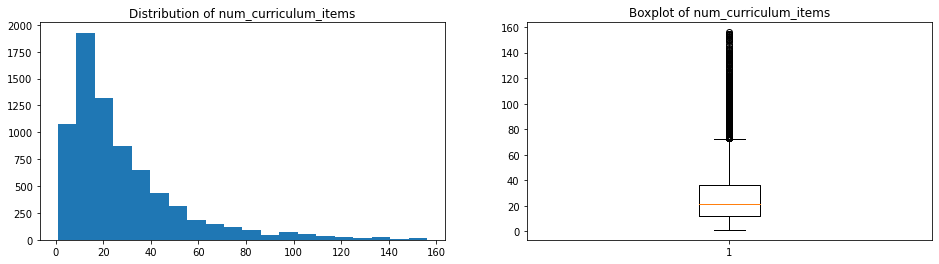

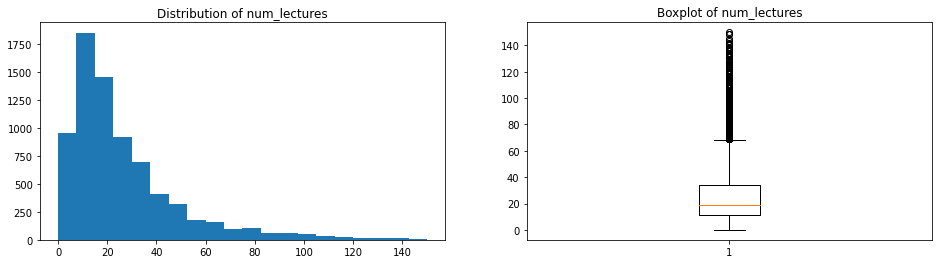

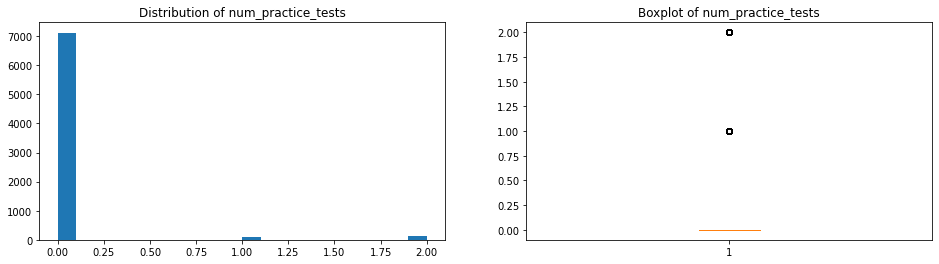

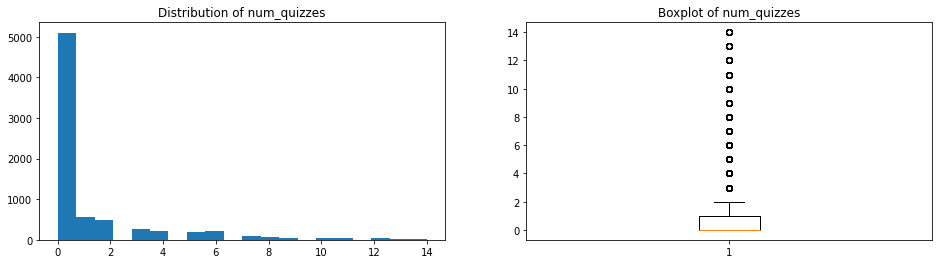

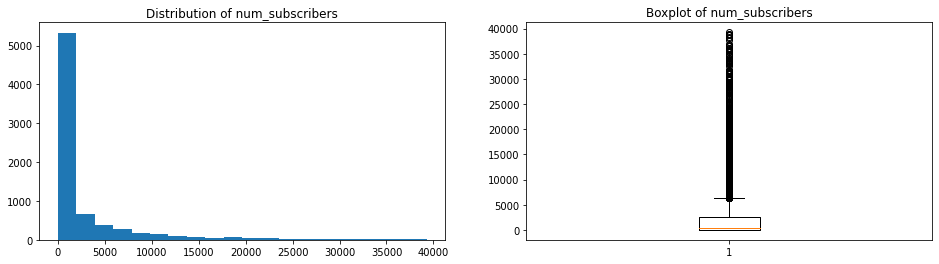

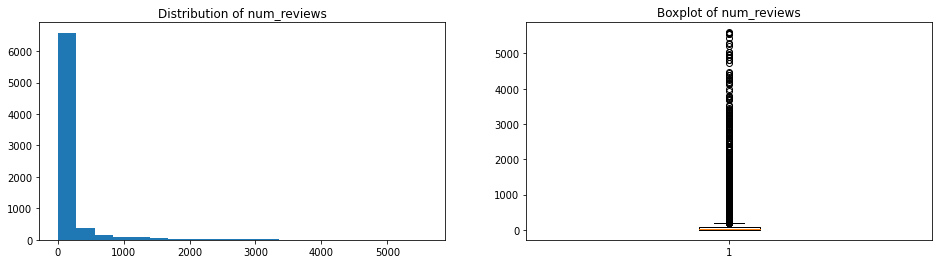

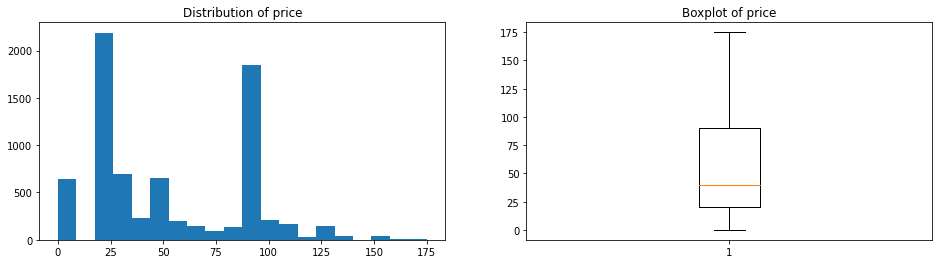

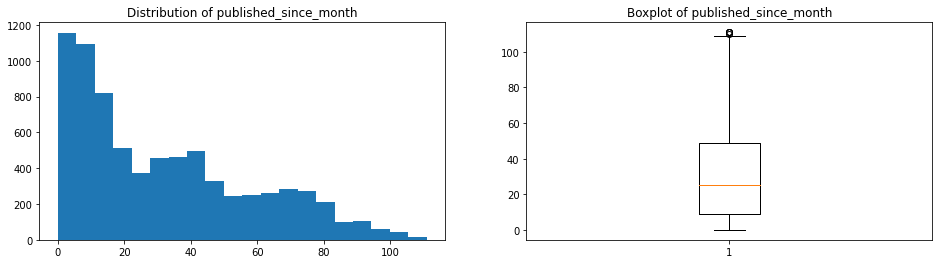

In [98]:
#There are some outliers in the dataset - I filtered out the data, where the value was smaller/larger then mean+-3*std
var_num=['avg_rating', 'avg_rating_recent','num_article_assets' , 'num_curriculum_items','num_lectures', 
         'num_practice_tests', 'num_quizzes','num_subscribers', 'num_reviews', 'price',  'published_since_month']
excluded_all=[]

for col in var_num:
    mean=df_courses[col].mean()
    std=df_courses[col].std()
    temp=df_courses[(df_courses[col]>mean-3*std) & (df_courses[col]<mean+3*std)]
    excluded_all.extend(list(set(df_courses.index)-set(temp.index)))
    fig, ax= plt.subplots(1,2,figsize=(16,4))
    ax[0].hist(temp[col], bins=20)
    ax[1].boxplot(temp[col])
    ax[0].set_title('Distribution of '+ str(col))
    ax[1].set_title('Boxplot of '+ str(col))
    print('Number of dropped values of attribute {} is {}.'.format(col, len(df_courses)-len(temp)))
excluded=set(excluded_all)

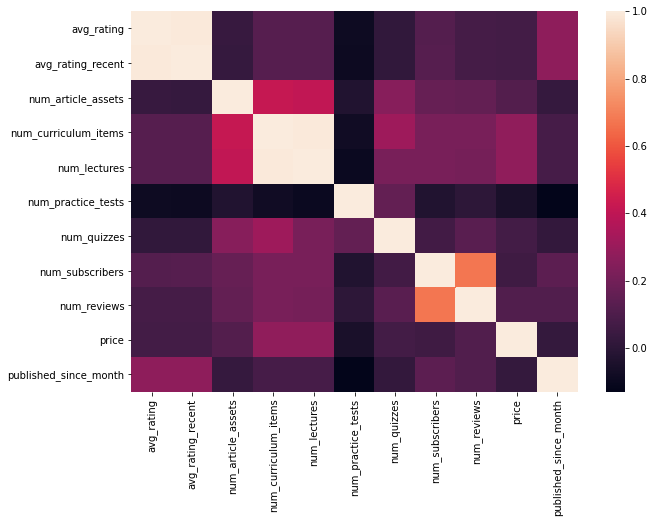

In [99]:
corr = df_courses[var_num].corr()
fig, ax=plt.subplots(figsize=(10,7))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

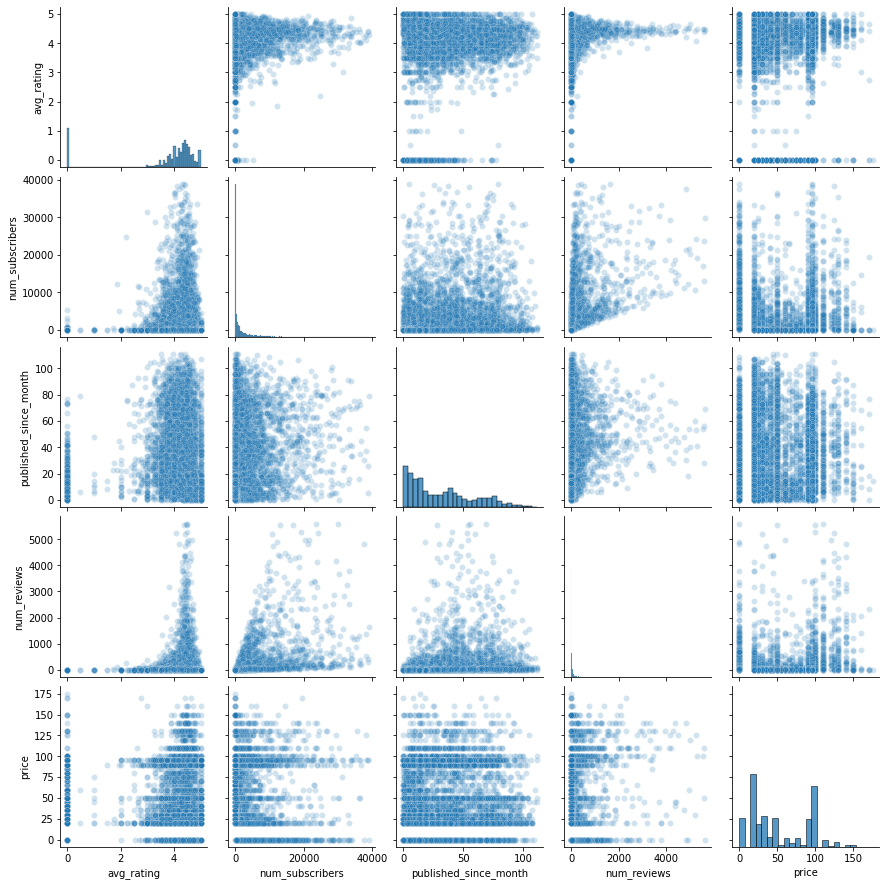

In [100]:
cols=['avg_rating','num_subscribers','published_since_month', 'num_reviews', 'price']
temp=df_courses[~df_courses.index.isin(excluded)]
sns.pairplot(temp[cols], plot_kws= {'alpha': 0.2})

The followings can be seen from the pairplot above:
- There is a positive correlation between the number of reviews/number of subscribers and the average rating - students normally give better ratings
- As expected, there is a positive correlation between number of subscribers and number of reviews
- There is also a positive correlation between published since and the average rating -> older courses have better ratings. This seems logic, since I would expect that courses which aren't popular won't stay long on the sortiment
- The price doesn't have an effect on the average ratings 

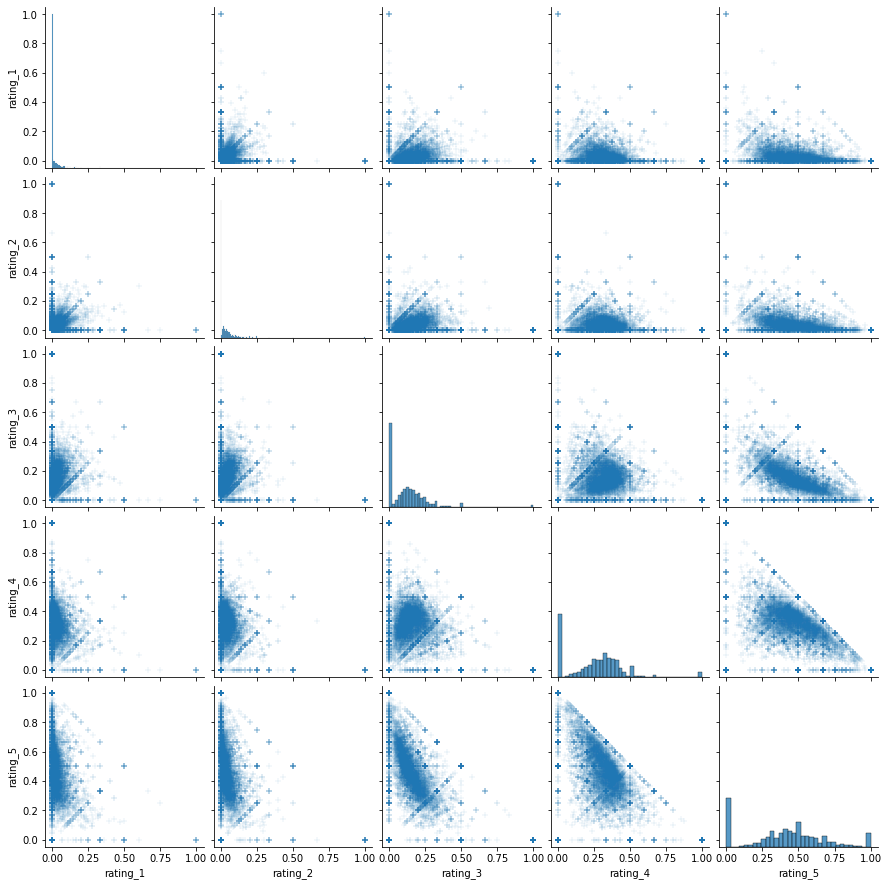

In [101]:
sns.pairplot(df_courses[['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']], markers="+",  plot_kws= {'alpha': 0.2})

#### Discrete variables

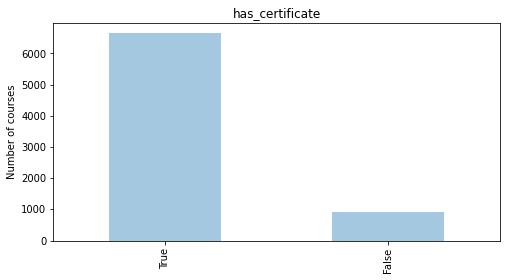

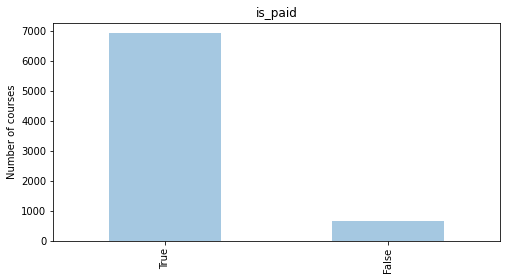

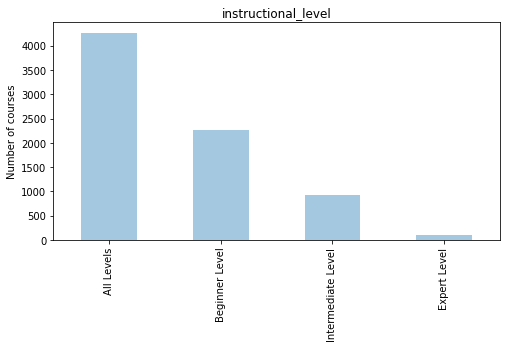

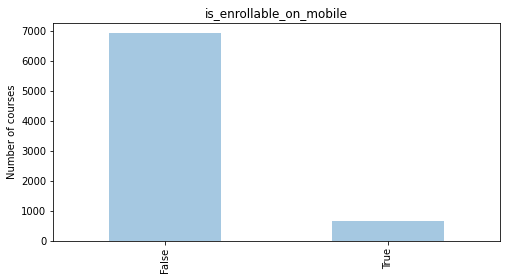

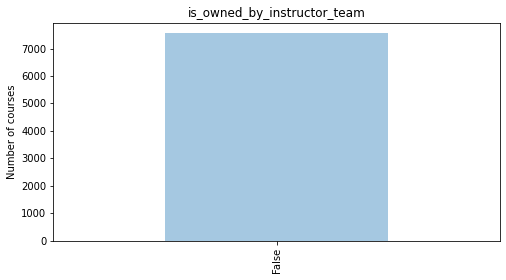

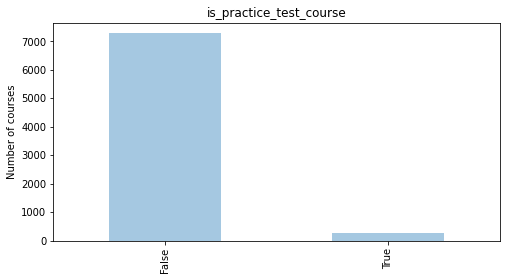

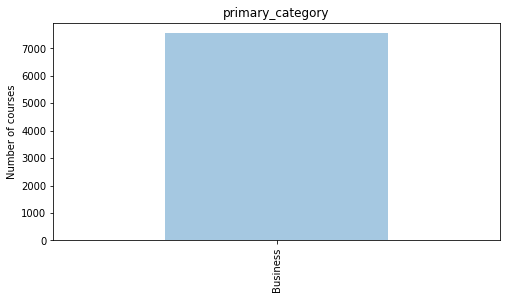

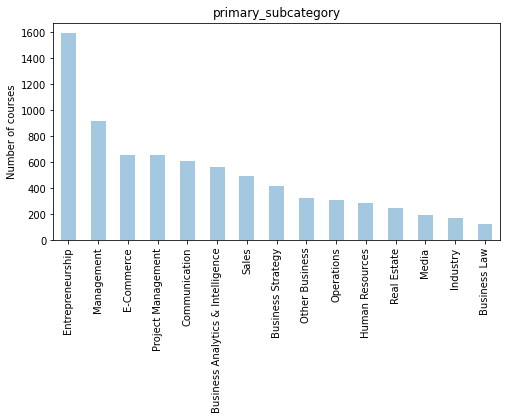

In [102]:
#barchart
var_char=['has_certificate', 'is_paid', 'instructional_level', 'is_enrollable_on_mobile','is_owned_by_instructor_team',
          'is_practice_test_course', 'primary_category', 'primary_subcategory' ]
for col in var_char:
    temp=df_courses[col].value_counts()
    x_labels=temp.index
    plt.figure(figsize=(8, 4))
    ax = temp.plot(kind='bar', alpha=0.4)
    ax.set_title(col)
    ax.set_ylabel('Number of courses')
    ax.set_xticklabels(x_labels)
  
    rects = ax.patches
    labels = list(temp.values/temp.values.sum()*100)
    labels=[str(round(l,0))+'%' for l in labels]
    #for rect, label in zip(rects, labels):
        #height = rect.get_height()
        #ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')
plt.show()

In [103]:
#number of subscribers in the categories
df_courses['earnings']=df_courses['price']*df_courses['num_subscribers']
df_subcategories=df_courses.groupby('primary_subcategory').agg({'num_subscribers':'sum',
                                               'avg_rating': 'mean',
                                               'price': 'mean',
                                               'earnings': 'sum'})    
df_subcategories

num_subscribers  ...      earnings
primary_subcategory                                 ...              
Business Analytics & Intelligence          4214709  ...  3.075999e+08
Business Law                                169513  ...  5.868878e+06
Business Strategy                          1088060  ...  6.824195e+07
Communication                              2950201  ...  1.975740e+08
E-Commerce                                 4324642  ...  2.031618e+08
Entrepreneurship                           5385044  ...  3.343825e+08
Human Resources                             666135  ...  3.935981e+07
Industry                                    228936  ...  1.182660e+07
Management                                 2144868  ...  1.392118e+08
Media                                       665708  ...  3.642243e+07
Operations                                  688061  ...  3.909176e+07
Other Business                              875806  ...  4.671434e+07
Project Management                         2324836  ...  1.626259e+08
Real Estate                                 532547  ...  4.694027e+07
Sales                                      1186842  ...  8.376575e+07

[15 rows x 4 columns]

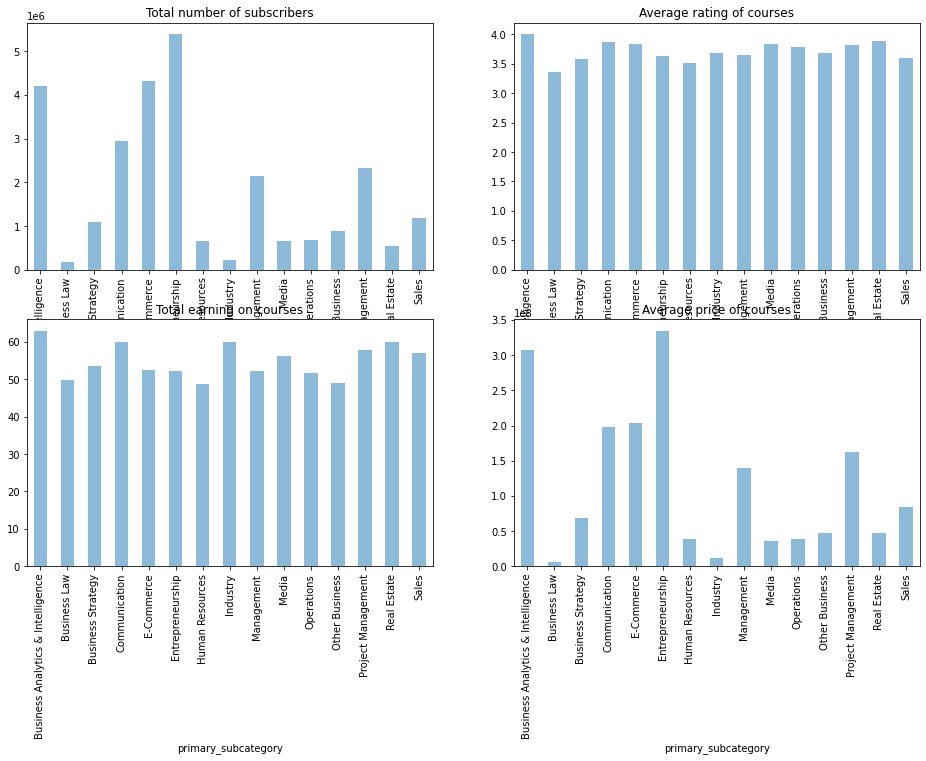

In [104]:
titles=['Total number of subscribers', 'Average rating of courses', 'Total earning on courses', 'Average price of courses']
fig, ax= plt.subplots(2,2,figsize=(16,10))
num=0
for i, col in enumerate(df_subcategories.columns):
    num+=1
    ax= plt.subplot(2,2, num)
    df_subcategories[col].plot(kind='bar', ax=ax, alpha=0.5)
    plt.title(titles[i])
    if num in range(3) :
        plt.tick_params(labelbottom='off')
plt.show()

- Two subcategories have an average price higher than 100 dollars : The subcategory Data & analytics with 112, and Project Management with 104
- The total earning on the courses is the highest in the subcategory for Data & Analytics and the second is in Entrepreneurship.
- The total number of subscribers are the highest in the category of Entrepreneurship and in Data & Analytics

#### Attribute Objectives

I will analyse the attribute objectives of the courses to get a better understanding about the courses. 
At first I needed to transform the list of objectives into one string, and then investigate the frequencies of each word.
I also implemented stemming: for that, I created a dataframe, where thee indexes are the stemmed words, and the values are the words which were stemmed. I needed it, to transform back the stemmed words. By means of the stemming similar words were counted as the same word (e.g. the words learn and learning are treated as one word). 

In [110]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [107]:
objectives_text=df_courses['objectives'].apply(combine_list)
vocab_frame_orig=vocab_stem(objectives_text)
vocab_frame_orig.head()

words
in         in
this     this
cours  course
,           ,
shani   shani

In [108]:
#drop duplicates from the dataframe with stemmed words
vocab_frame=drop_words(vocab_frame_orig)

In [111]:
StopWords=set(stopwords.words('english')+list(punctuation)+["’", "n't", "'s", "--", "-", "...", "``", "''", "“", "039"])

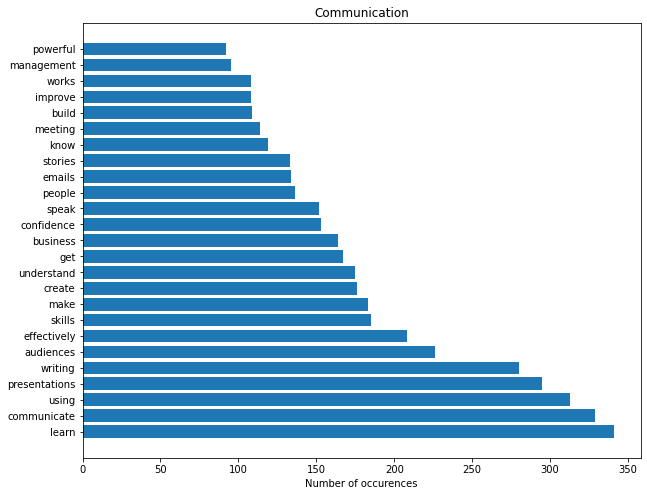

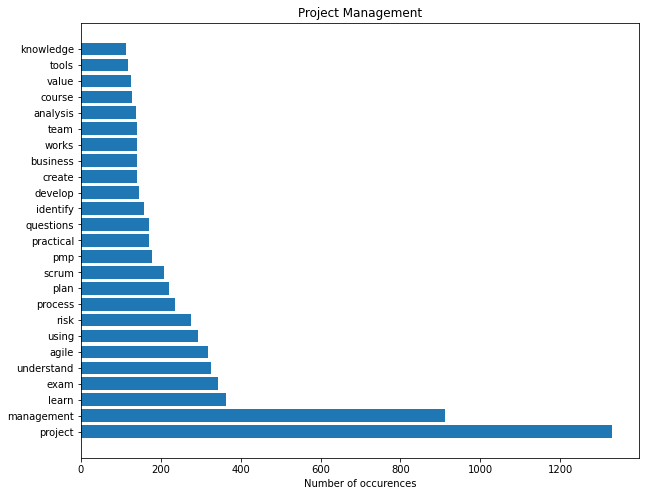

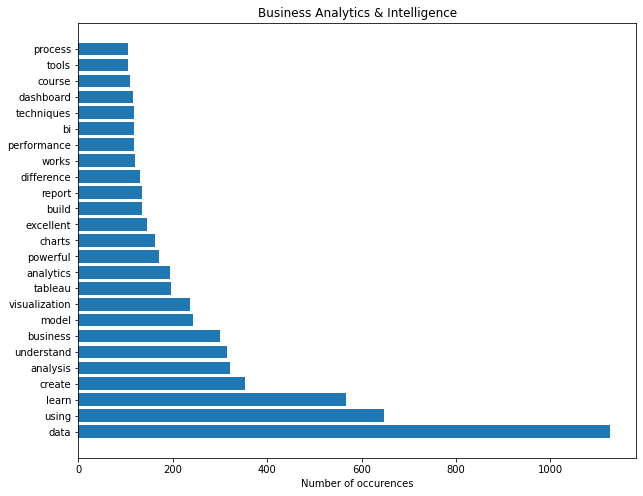

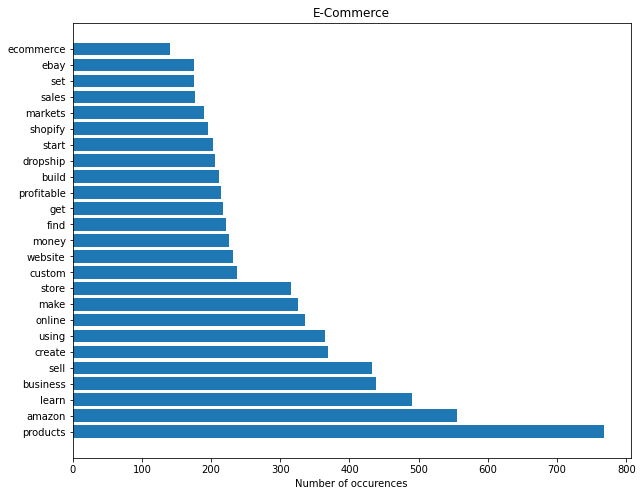

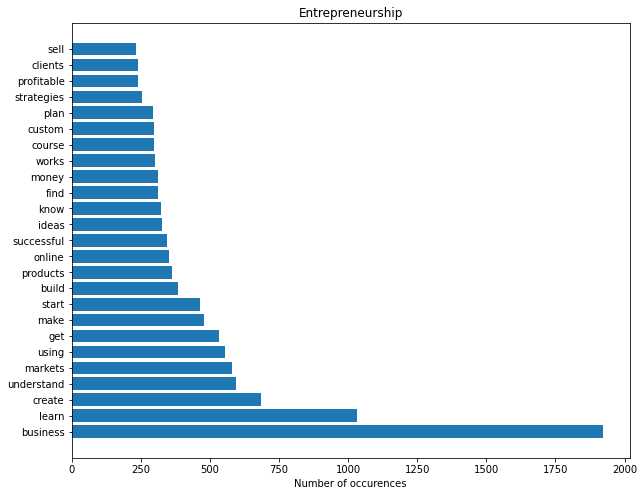

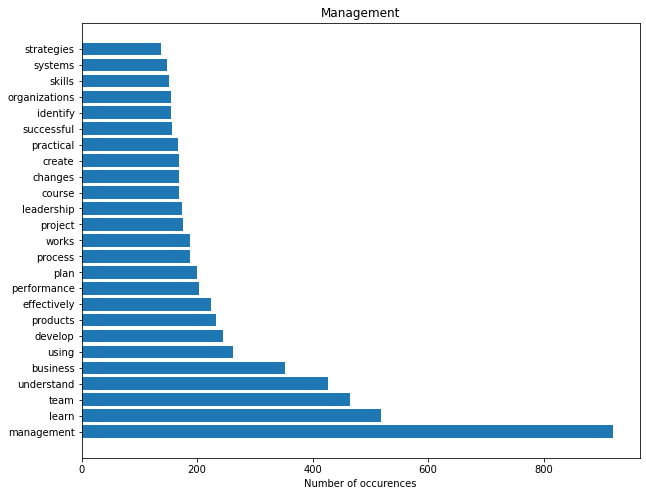

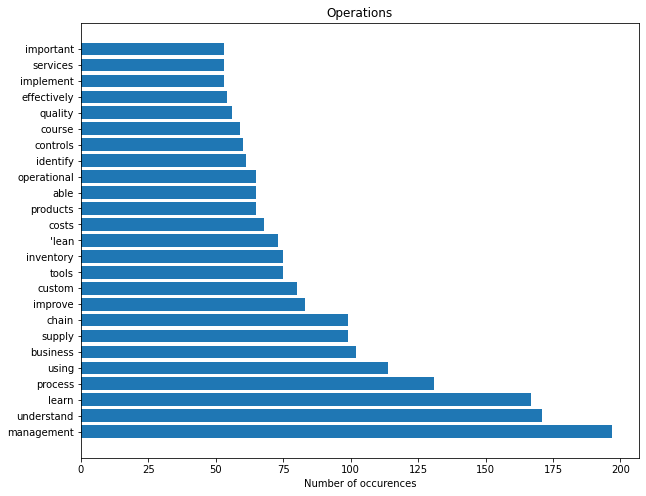

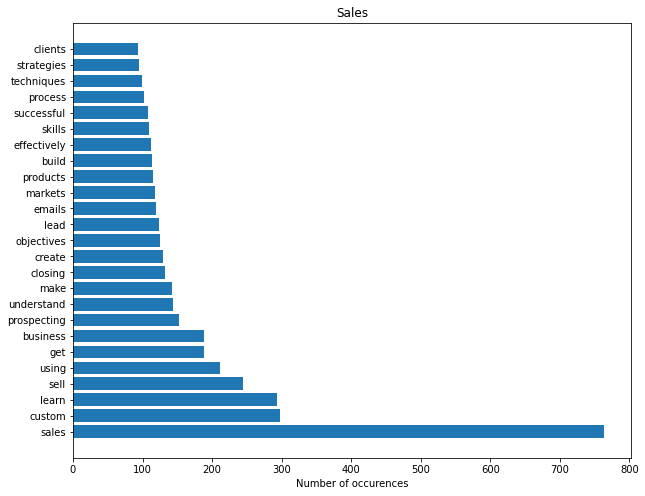

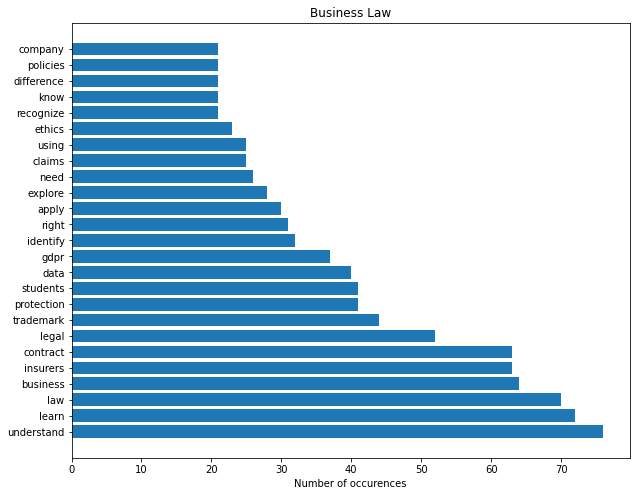

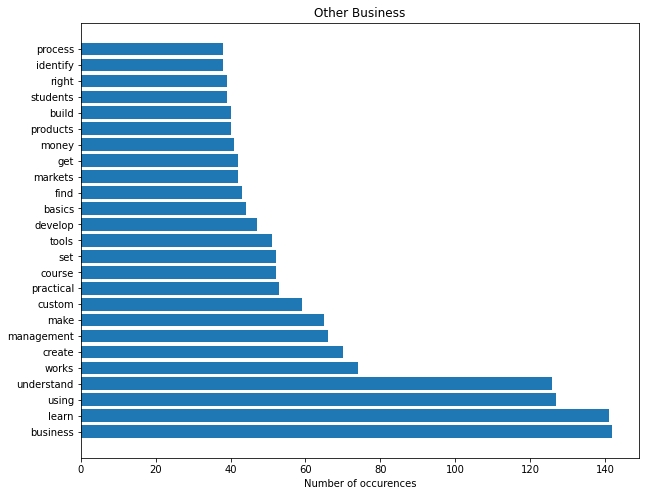

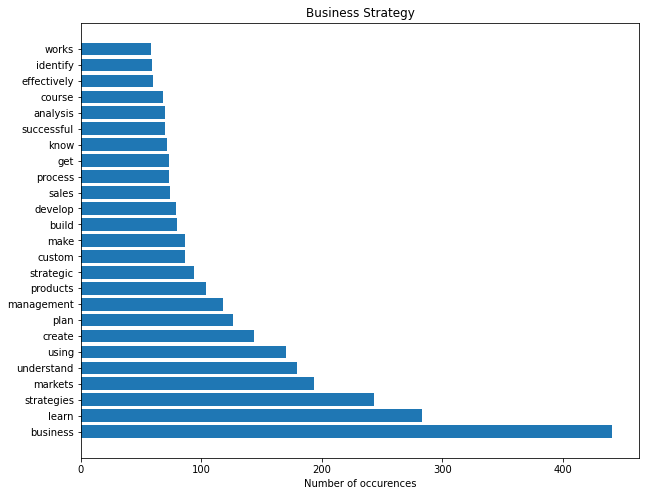

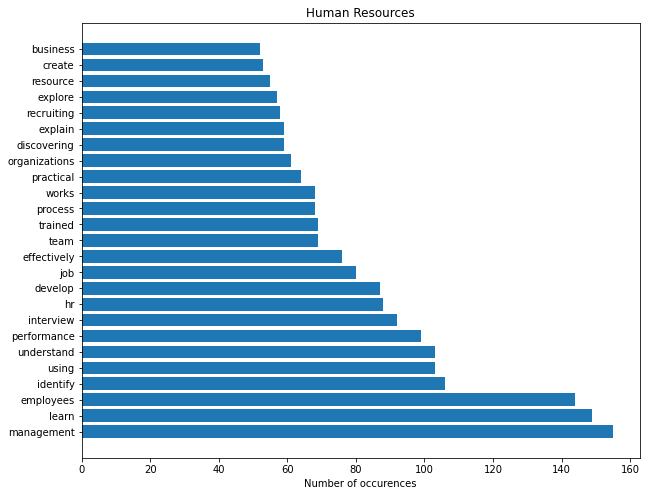

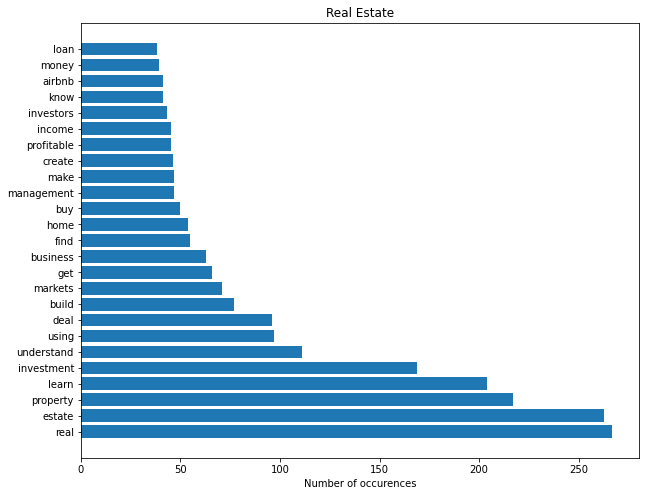

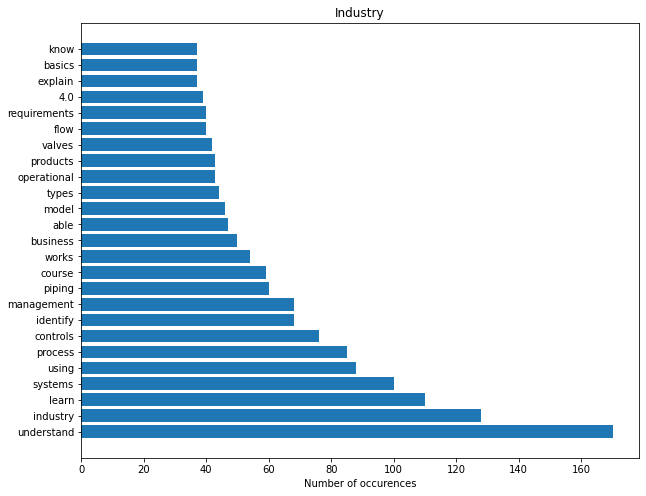

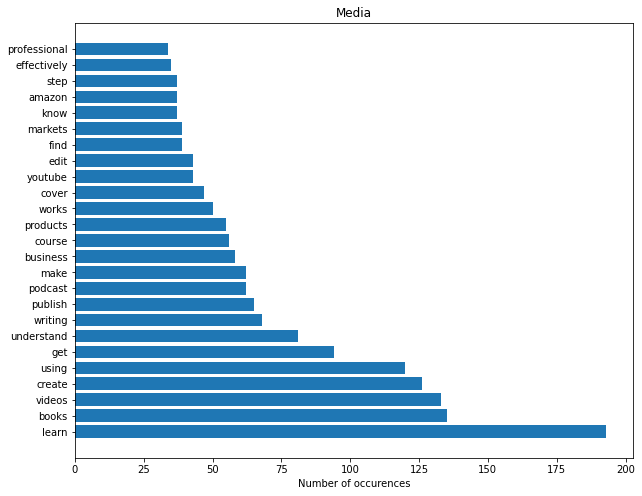

In [112]:
top_words_graph(df_courses, 'objectives', True, 'bar', StopWords, vocab_frame)

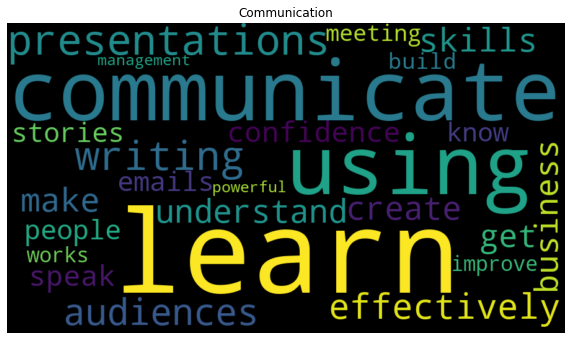

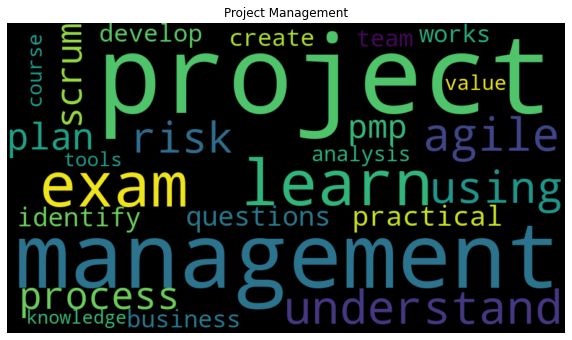

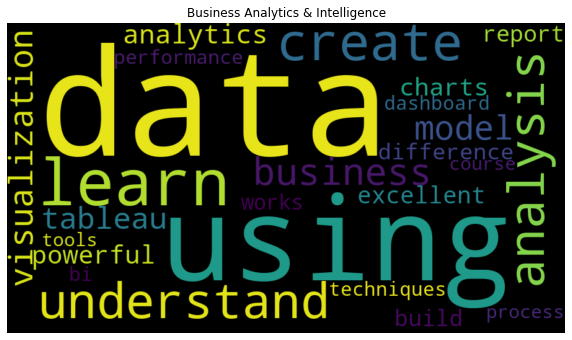

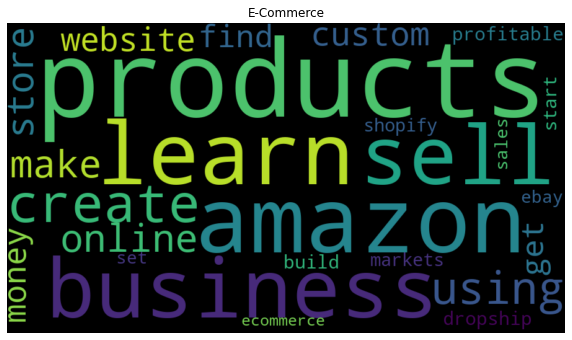

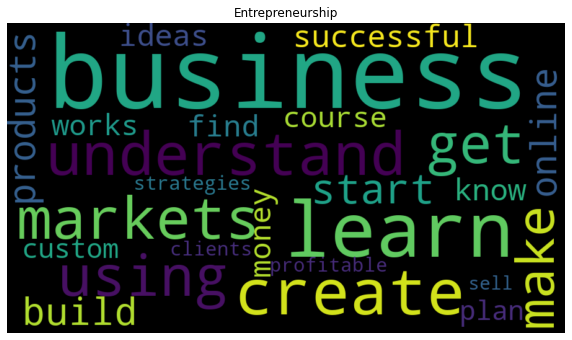

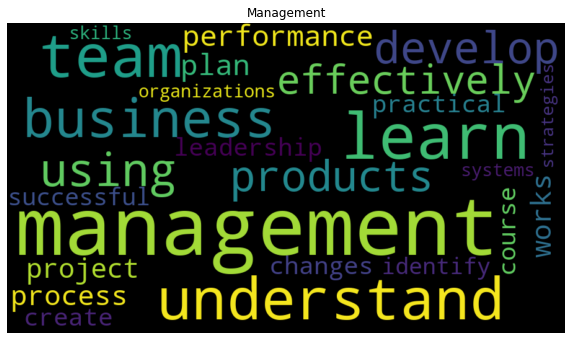

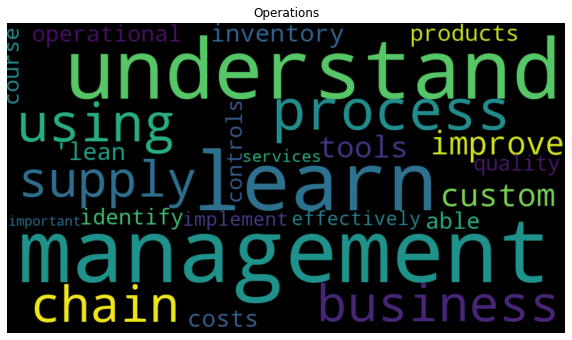

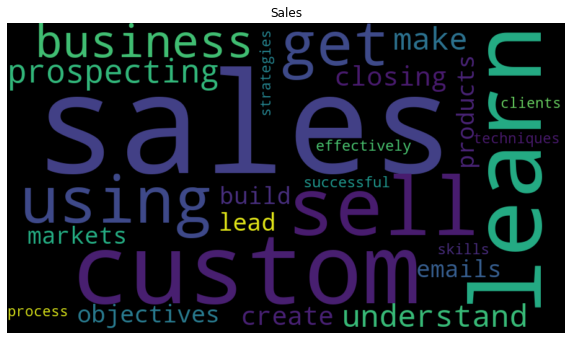

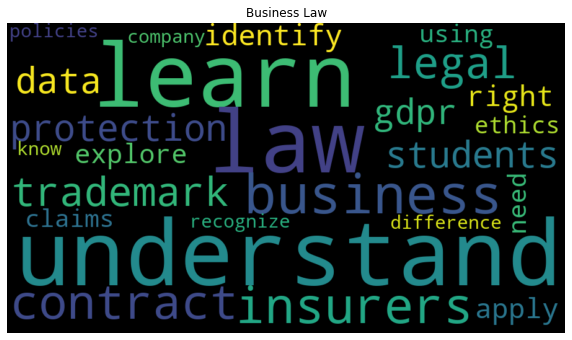

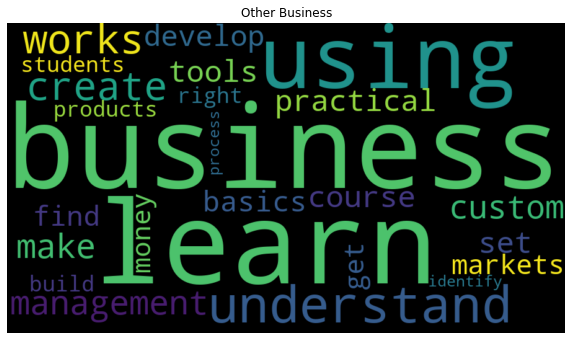

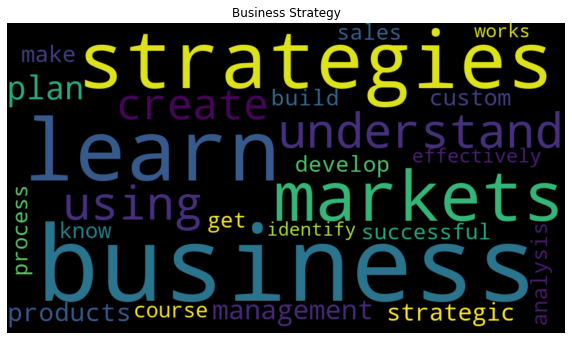

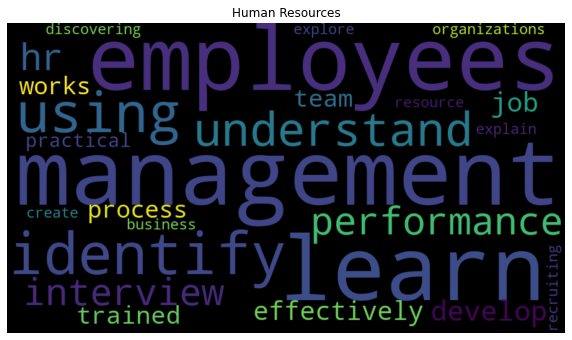

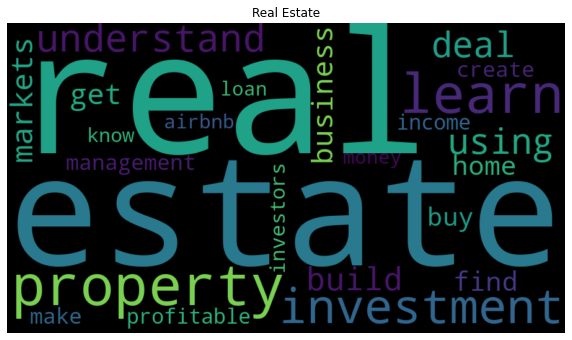

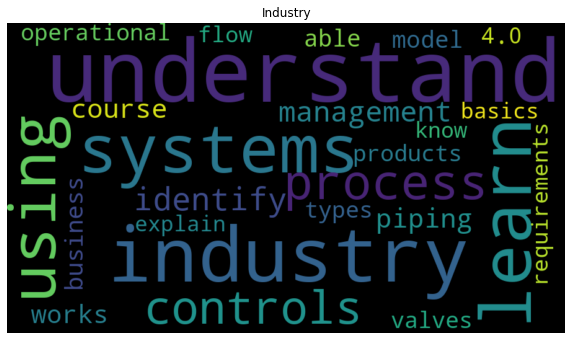

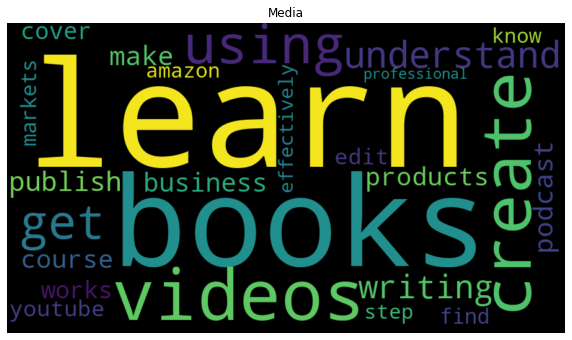

In [113]:
top_words_graph(df_courses, 'objectives', True, 'wordcloud', StopWords, vocab_frame)

#### Attribute Description

In [114]:
vocab_frame_descr=vocab_stem(df_courses['description_text'])
vocab_frame_descr.head()

words
secret  secret
&            &
nbsp      nbsp
;            ;
sauc     sauce

In [115]:
vocab_frame_descr=drop_words(vocab_frame_descr)

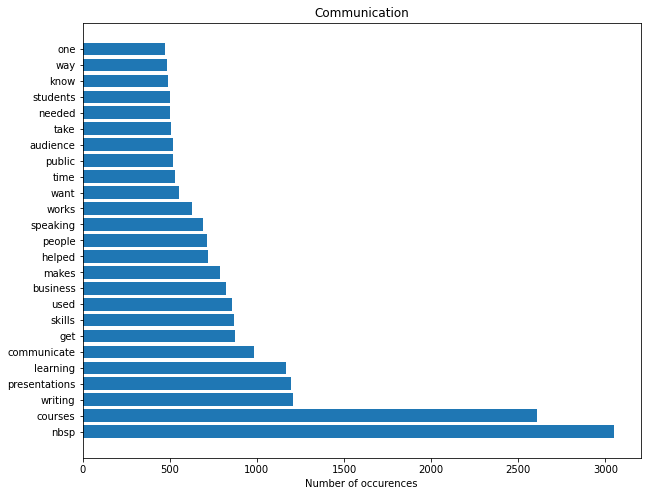

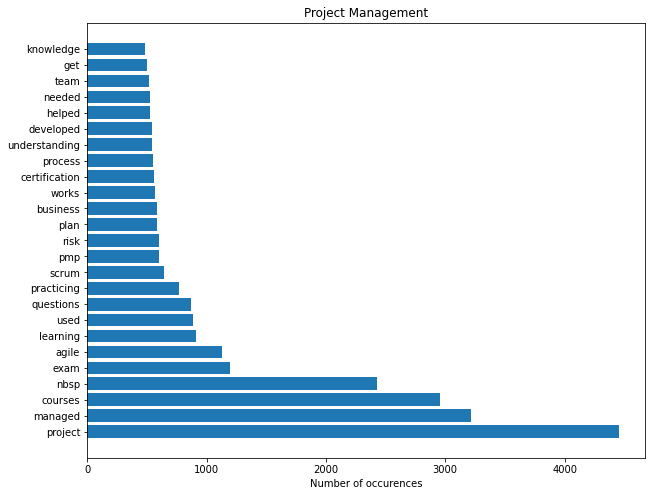

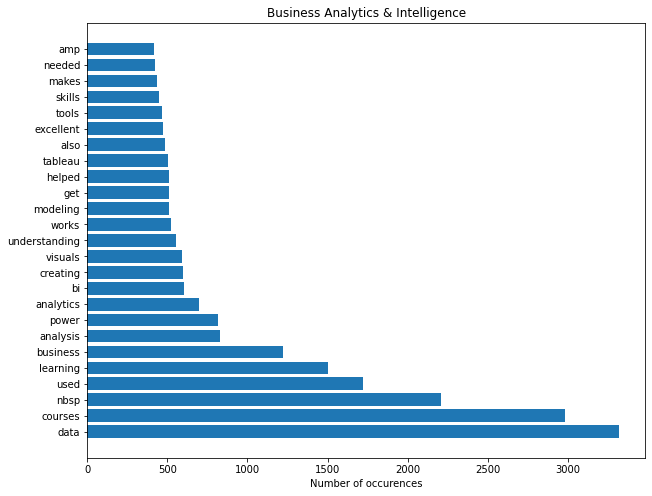

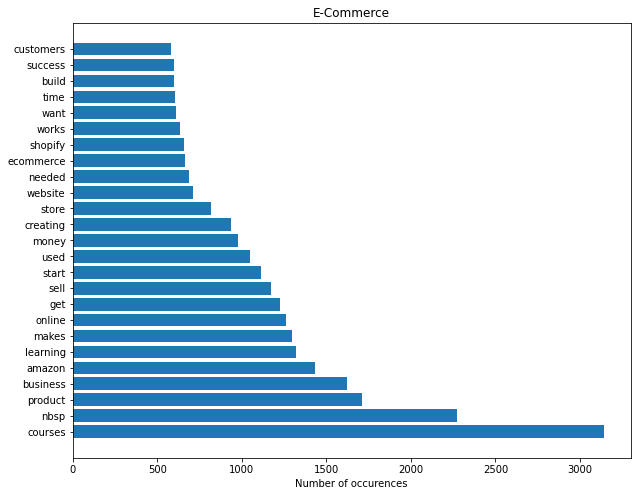

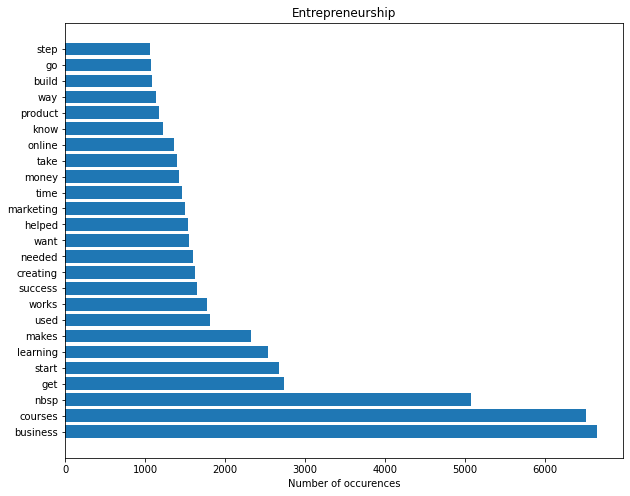

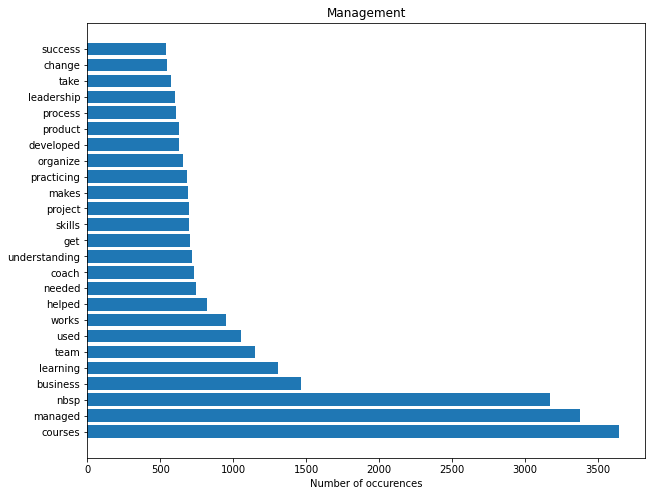

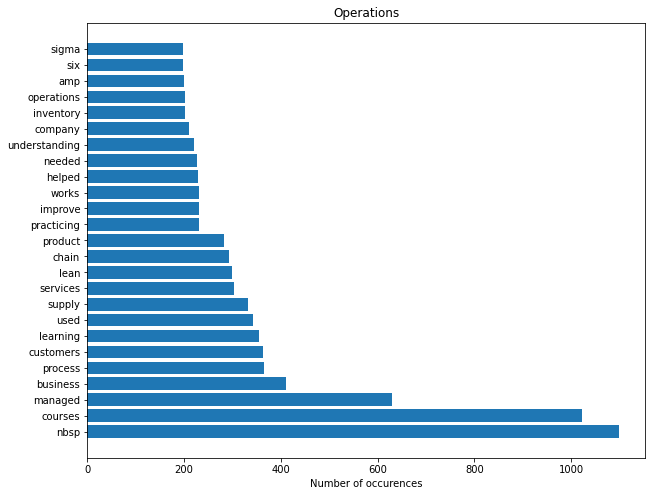

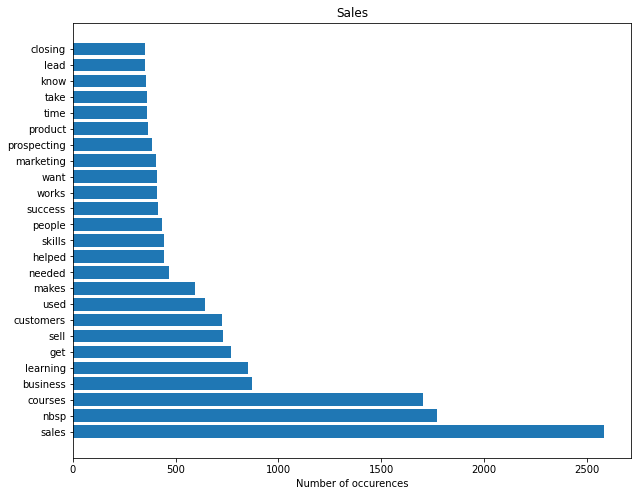

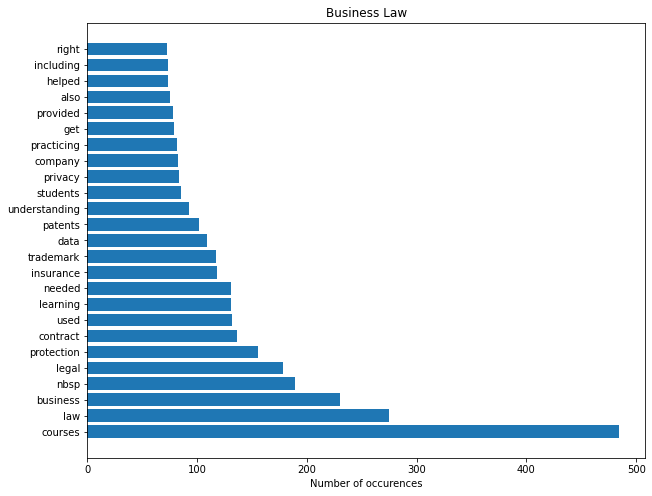

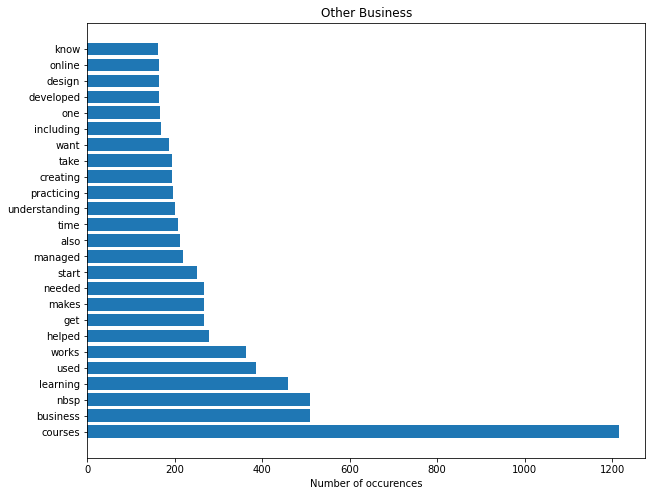

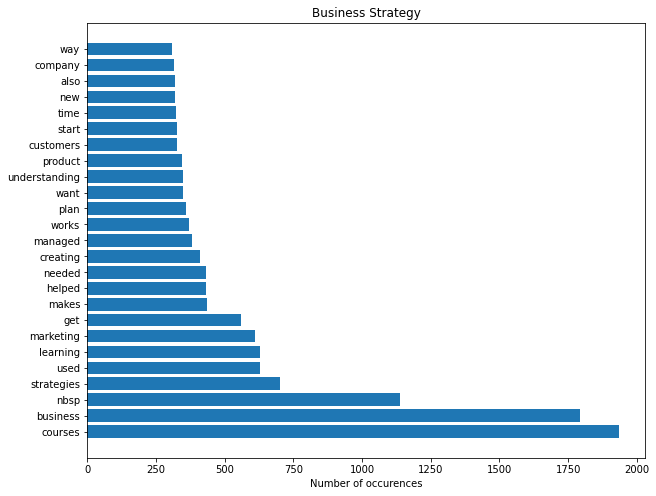

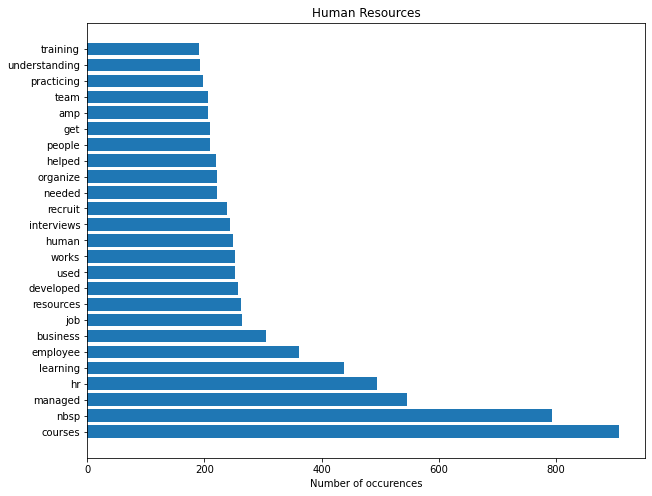

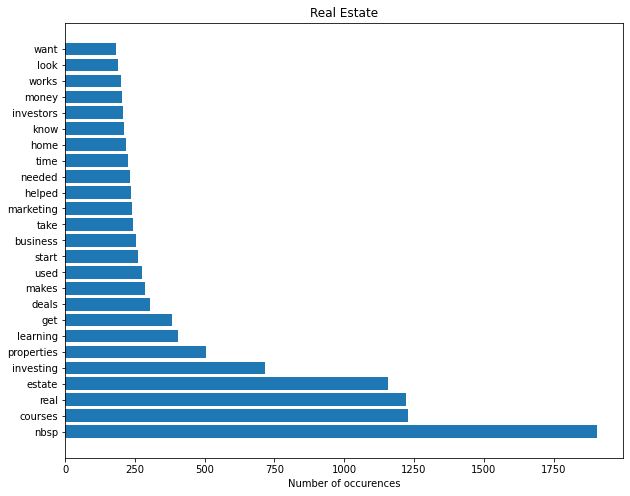

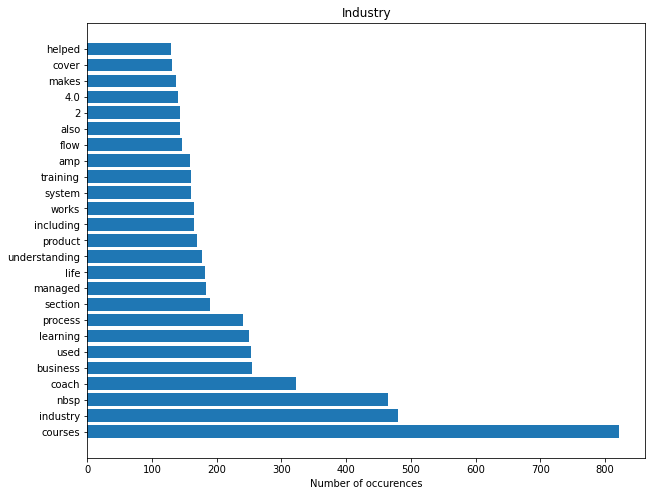

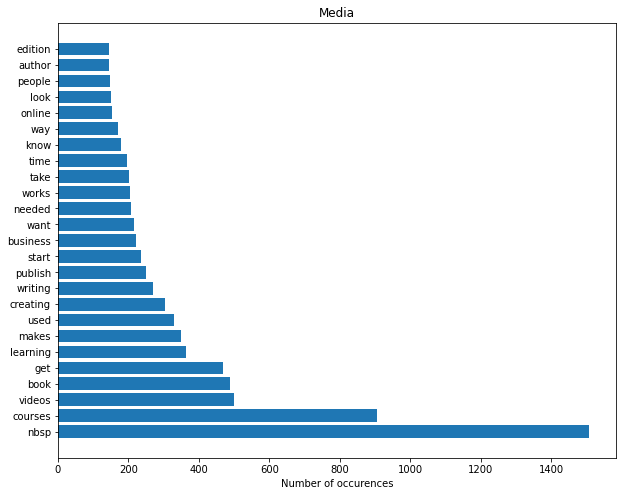

In [116]:
top_words_graph(df_courses, 'description_text', False, 'bar', StopWords, vocab_frame_descr)

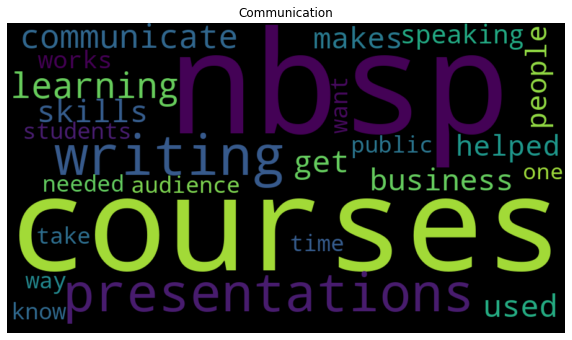

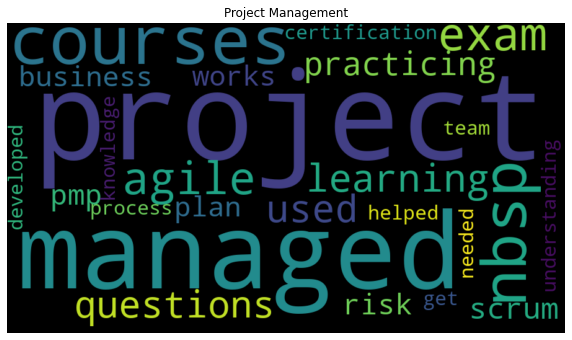

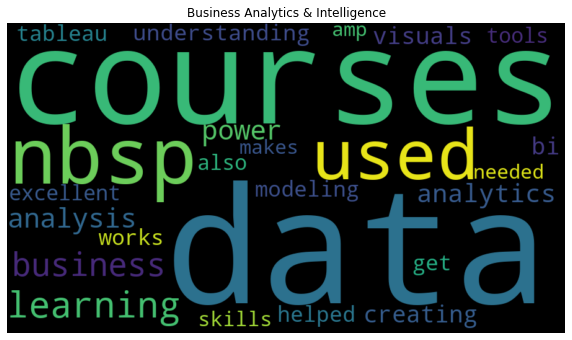

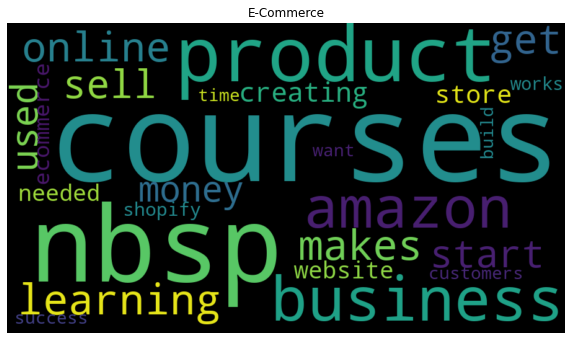

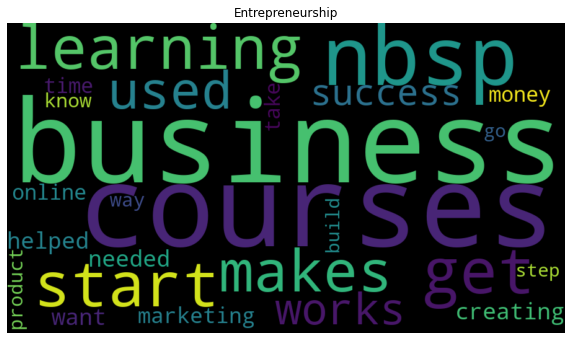

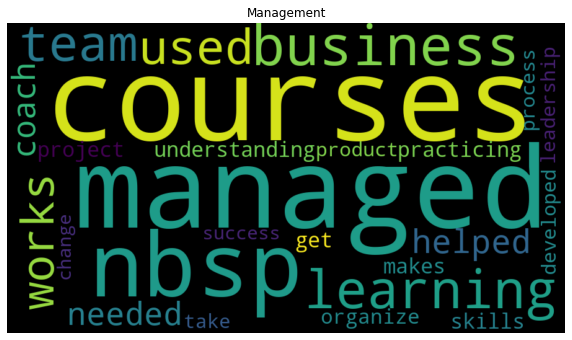

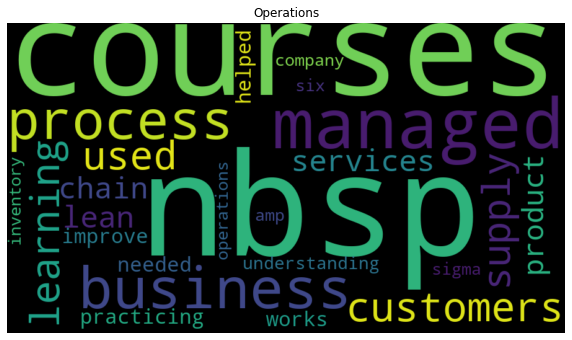

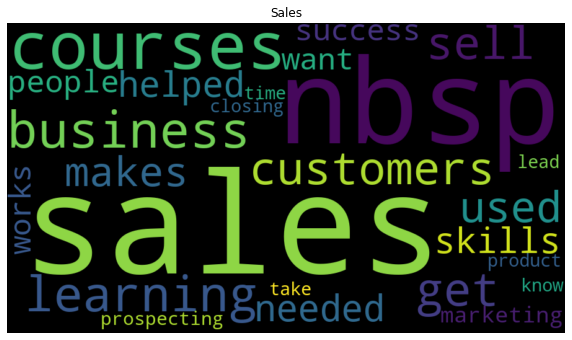

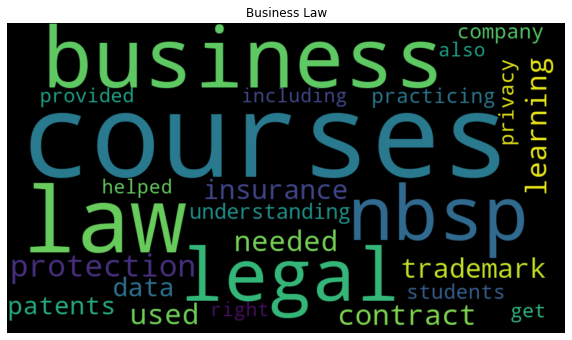

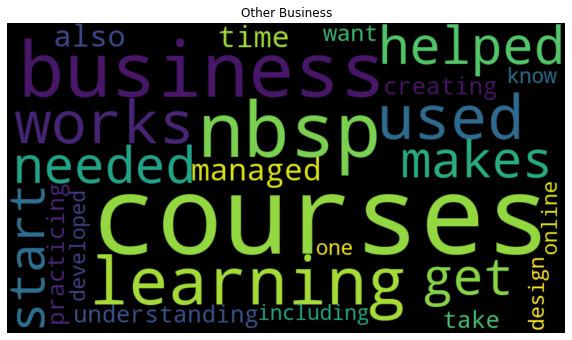

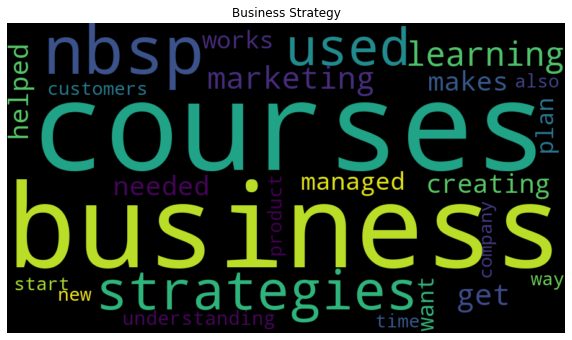

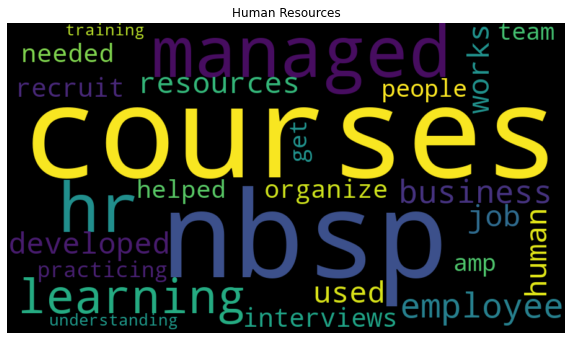

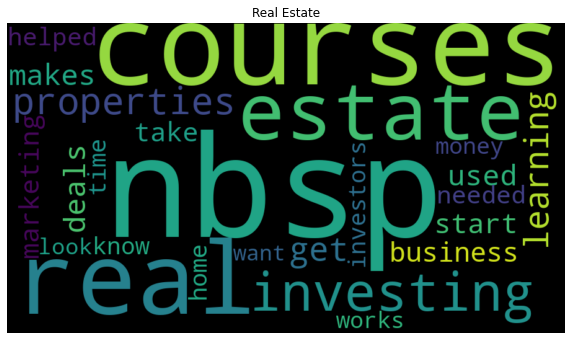

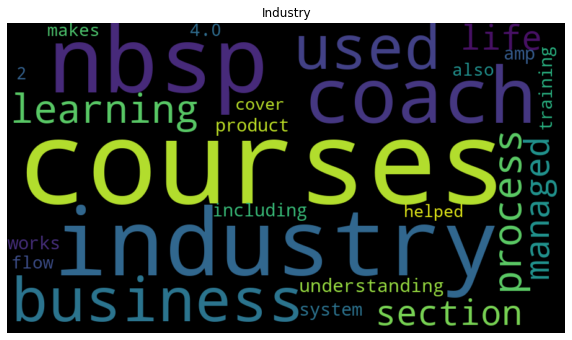

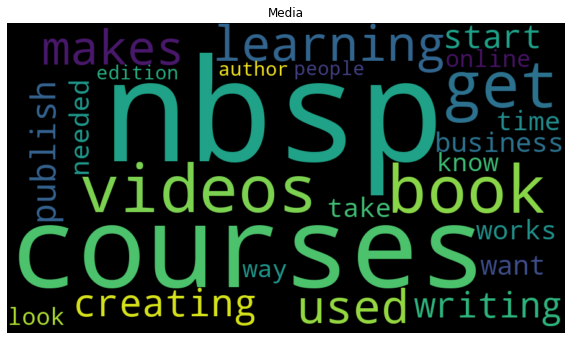

In [117]:
top_words_graph(df_courses, 'description_text', False, 'wordcloud', StopWords, vocab_frame_descr)

### EDA of the reviews dataset

In [118]:
df_reviews=pd.read_csv('df_reviews.csv', index_col=0)
df_reviews.head()

id               created  rating                     user_name
0  37926532  2019-09-26T14:14:13Z     5.0                 Ryan McGovern
1  37914794  2019-09-26T09:04:09Z     3.0  Mohammad Rashad Nadeer Kutty
2  37851504  2019-09-25T07:33:44Z     5.0                    Arth Patel
3  37835876  2019-09-25T02:08:23Z     5.0              A Kowsar Parveen
4  37834428  2019-09-25T01:30:27Z     5.0                     A Nirmala

In [121]:
#Number of reviews per user_name (User_name is not unique!)
nr_user=df_reviews['user_name'].value_counts()
unique, counts = np.unique(nr_user, return_counts=True)
#dict(zip(unique, counts))

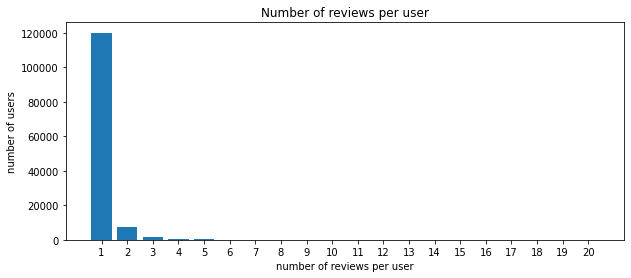

In [122]:
#plot the first 20 value of the most common number of reviews per user
#most users (more than 600000) have only 1 review
ax, fig= plt.subplots(figsize=(10,4))

plt.bar(np.arange(len(counts[:20])), counts[:20], align='center')
plt.xticks(np.arange(len(counts[:20])), unique[:20])
plt.xlabel('number of reviews per user')
plt.ylabel('number of users')
plt.title('Number of reviews per user')
plt.show()

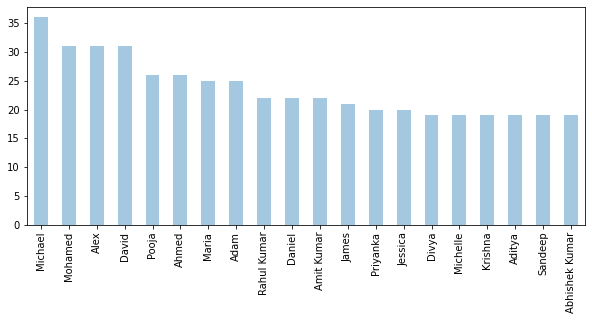

In [123]:
#plot the usernames with the most reviews (Username is not unique)
ax, fig= plt.subplots(figsize=(10,4))
nr_user[:20].plot(kind='bar', alpha=0.4)

## Clustering and Recommender system

In this section, I cluster the courses and based on the new clusters and other course features, I build a recommender system.

For the clustering I investigated the attributes OBJECTIVES and DESCRIPTION. After the preparation of these two attributes, the first part of the notebook tries to cluster the courses based on the attribute OBJECTIVES, while in the second part I build the clusters by means of the course DESCRIPTIONs. After comparing the results, I used the the clustering algorithm based on the description field. The last part of the notebook shows the recommender system,  that helps the user to find similar courses to the previously taken ones.

In [125]:
import pandas as pd
import numpy as np
import ast
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import pickle

### Prepare the data

In [126]:
df_courses=pd.read_csv('df_courses.csv', index_col=0, sep=' ', converters={"objectives": ast.literal_eval})
df_courses.head()

avg_rating  ...                primary_subcategory
0    4.483728  ...                      Communication
1    4.452830  ...                      Communication
2    4.509386  ...                 Project Management
3    4.117857  ...  Business Analytics & Intelligence
4    4.490196  ...                         E-Commerce

[5 rows x 28 columns]

In [127]:
df_reviews=pd.read_csv('df_reviews.csv', index_col=0)
df_reviews.head()

id               created  rating                     user_name
0  37926532  2019-09-26T14:14:13Z     5.0                 Ryan McGovern
1  37914794  2019-09-26T09:04:09Z     3.0  Mohammad Rashad Nadeer Kutty
2  37851504  2019-09-25T07:33:44Z     5.0                    Arth Patel
3  37835876  2019-09-25T02:08:23Z     5.0              A Kowsar Parveen
4  37834428  2019-09-25T01:30:27Z     5.0                     A Nirmala

### Pepare the attribute OBJECTIVES

The feature Objectives is a list of course objectives. At first I make a string from the list items by means of the function combine_list. 

For the stemming I saved all words with their stemmed correspondence in the dataframe vocab_frame. Since I am interested only in the stemmed words, I dropped all the duplicates from this dataframe (e.g. I treat learn and learning as the same words). This dataframe will be used to transform back the stemmed words. 

I defined the StopWords which contains all the expression that shouldn't be considered from the texts. 

Finally I applied the TfidfVectorizer on the objectives attribute: This transformator builds feature vectors from text documents so, that it helps to identify words which are frequent in the text but rare in the corpus.

In [128]:
objectives_text=df_courses['objectives'].apply(combine_list)

In [129]:
vocab_frame_orig=vocab_stem(objectives_text)
#drop duplicates from the dataframe with stemmed words
vocab_frame=drop_words(vocab_frame_orig)

In [130]:
StopWords=set(stopwords.words('english')+list(punctuation)+["’", "n't", "'s", "--", "-", "...", "``", "''", "“", "039"])

In [131]:
#use TfidfVectorizer 
vectorizer= TfidfVectorizer(stop_words=StopWords, tokenizer=tokenize, max_features=1000, max_df=0.8)
X=vectorizer.fit_transform(objectives_text)
X.shape

(7550, 1000)

In [132]:
word_features = vectorizer.get_feature_names()
word_features[50:55]

['analysi', 'analyst', 'analyt', 'analyz', 'ani']

### Prepare the attribute DESCRIPTION

I executed the same steps as by the attribute Objectives except the combine_list functions: the attribute Description is alredy a string and not a list.

In [133]:
vocab_frame_descr=vocab_stem(df_courses['description_text'])
vocab_frame_descr=drop_words(vocab_frame_descr)

In [134]:
StopWords=set(stopwords.words('english')+list(punctuation)+["’", "n't", "'s", "--", "-", "...", "``", "''", "“", "039"])

In [135]:
#use TfidfVectorizer
vectorizer_descr= TfidfVectorizer(stop_words=StopWords, tokenizer=tokenize, max_features=1000, max_df=0.8)
X_descr=vectorizer_descr.fit_transform(df_courses['description_text'])
X_descr.shape

(7550, 1000)

In [136]:
word_features_descr = vectorizer_descr.get_feature_names()
word_features_descr[50:55]

['almost', 'along', 'alreadi', 'also', 'alway']

## Clustering with the OBJECTIVES

### K-Means Clustering - with k=15 clusters

At first I tried to create 15 clusters - there are 16 subcategories, but no need for category 'others'.

In [137]:
kmeans = KMeans(n_clusters = 15, n_init = 10, n_jobs = -1, random_state=1234)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=1234, tol=0.0001, verbose=0)

In [138]:
common_words=get_common_words(kmeans, 10)
print_common_words(common_words, word_features, vocab_frame)

0 : data, visualization, using, analysis, learn, create, tableau, charts, dashboard, analytics
1 : learn, using, business, get, understand, create, course, works, markets, effectively
2 : project, management, risk, plan, using, understand, learn, schedule, scope, controls
3 : exam, pmp, questions, passing, practical, prepared, certification, tested, management, project
4 : products, amazon, sell, store, shopify, dropship, find, fba, create, custom
5 : business, markets, start, plan, understand, successful, ideas, strategies, create, grow
6 : presentations, communicate, audiences, speak, interview, confidence, skills, effectively, using, meeting
7 : writing, books, emails, publish, amazon, kindle, create, ebook, learn, using
8 : online, website, money, make, create, wordpress, business, income, start, build
9 : sales, custom, closing, sell, prospecting, learn, lead, techniques, markets, objectives
10 : team, coaching, management, leadership, develop, employees, leaders, works, motivate,

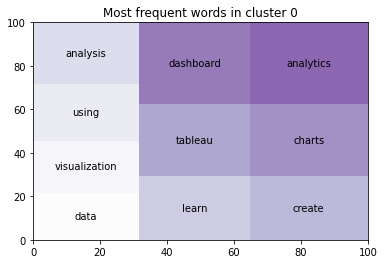

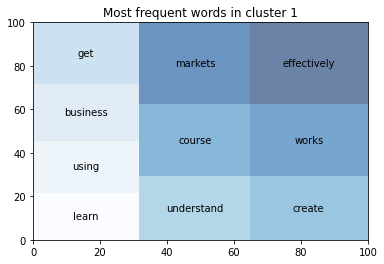

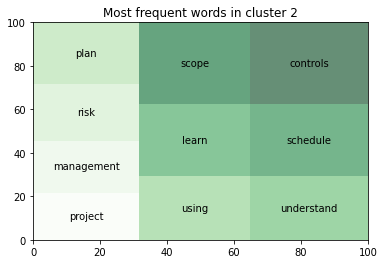

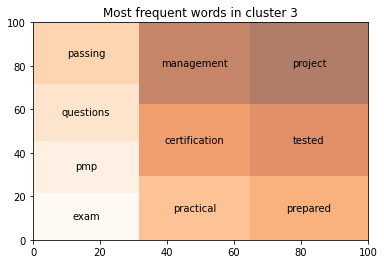

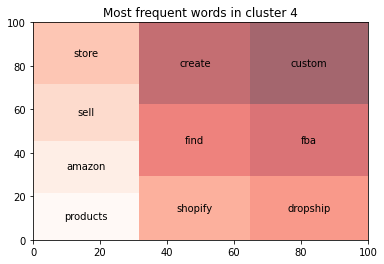

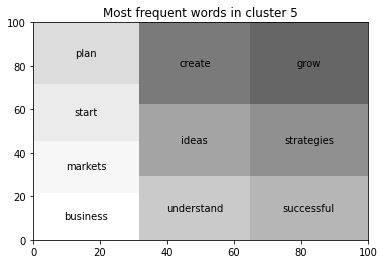

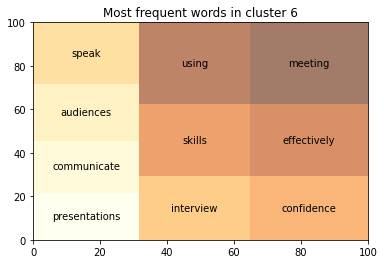

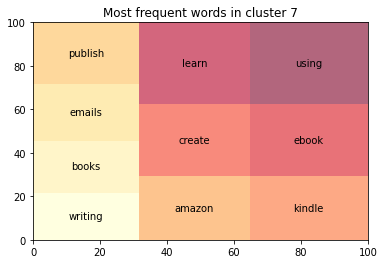

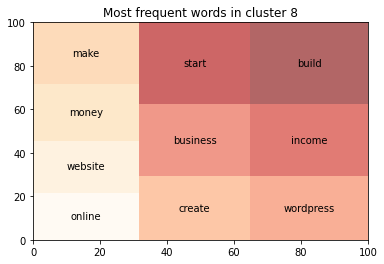

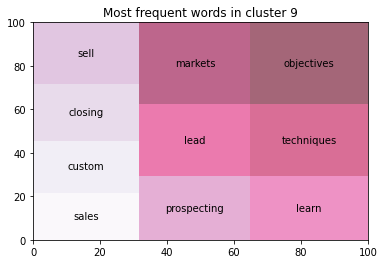

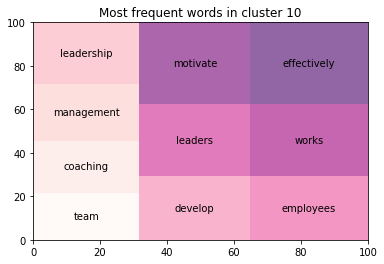

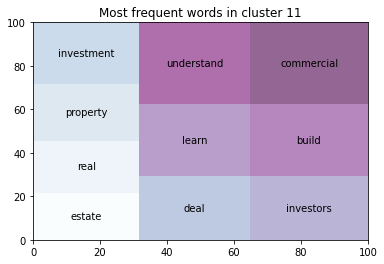

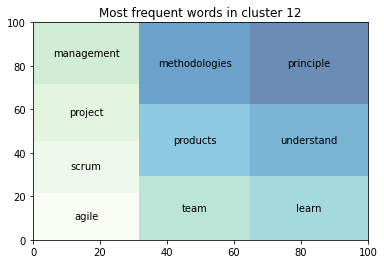

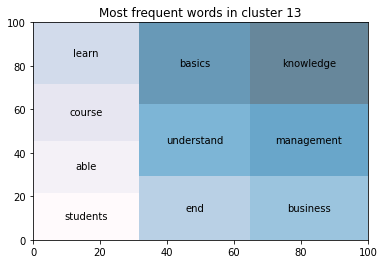

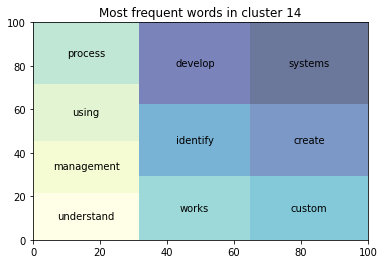

In [139]:
#plot the top10 most frequent words in each cluster
squarify_words(common_words, word_features, vocab_frame)

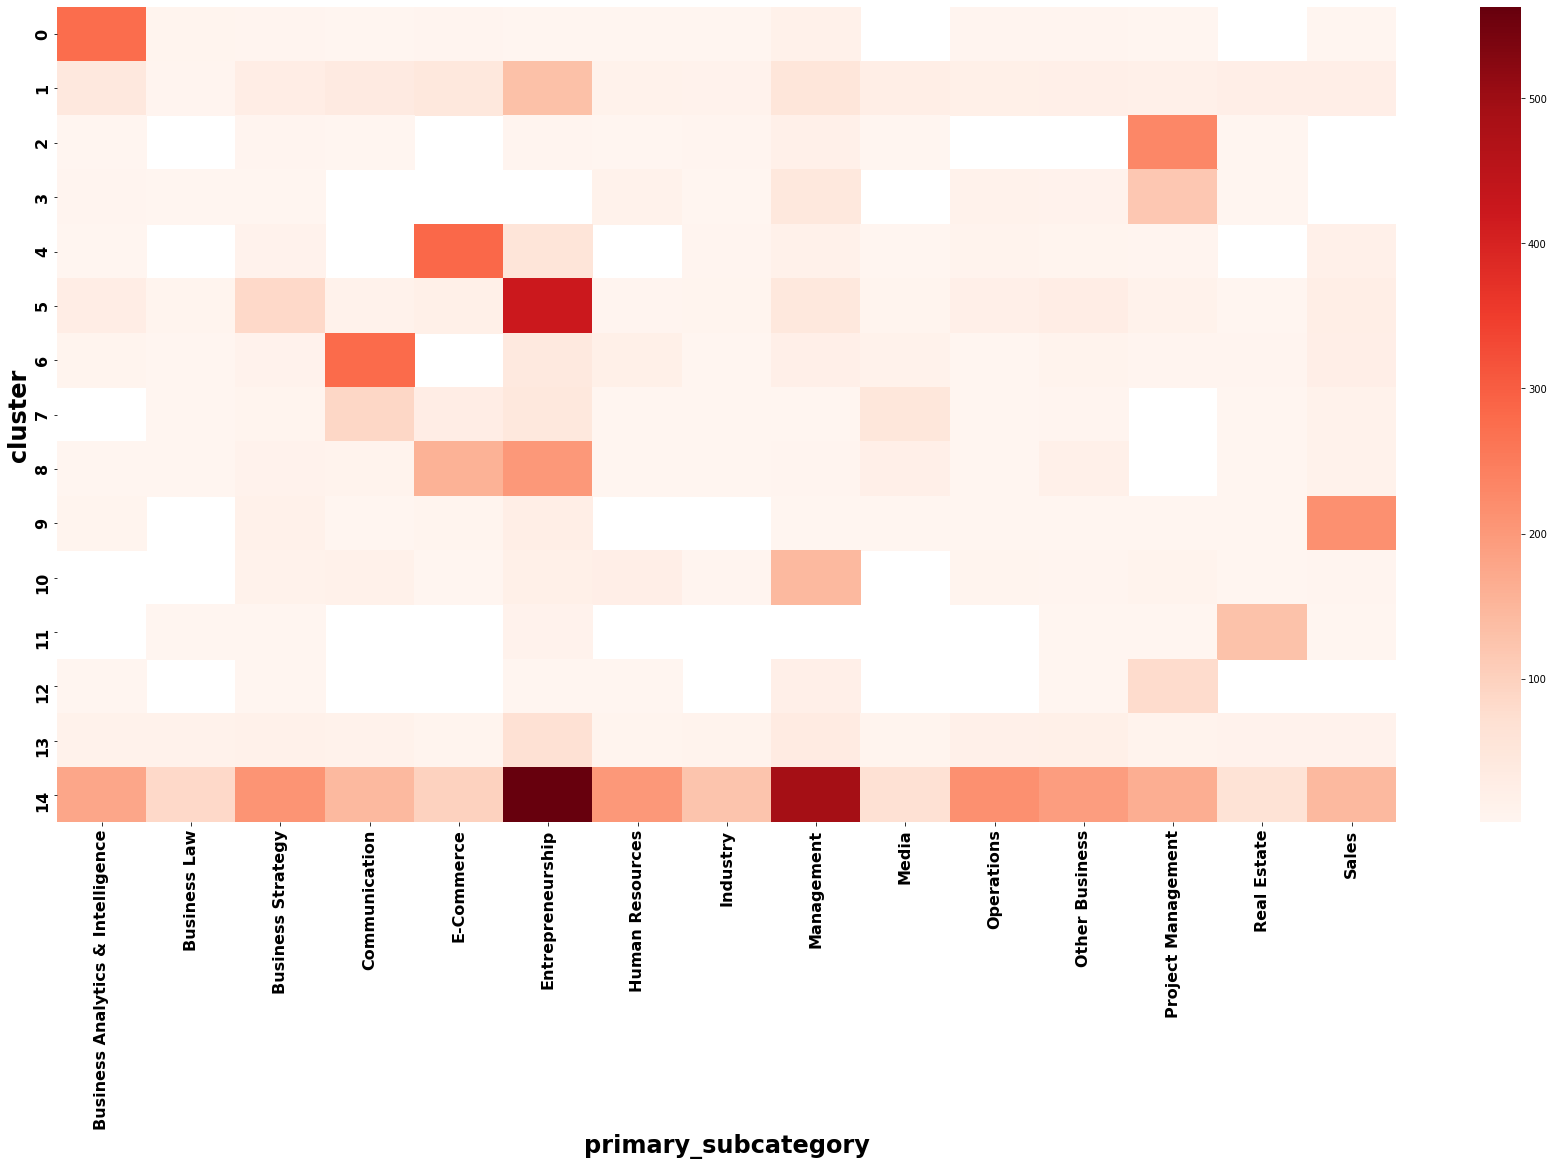

In [140]:
#heatmap of the new clusters with the subcategories
df_courses['cluster']=kmeans.labels_
heatmap_categories_cluster('cluster', df_courses, 'Reds' )

### Relationship between number of clusters (k) and inertia

I investigated the relationship between the number of clusters and the inertia (within-cluster sum-of-squares ) to find to optimal number of clusters. According to the elbow method, the line is an arm and the "elbow" on the arm is the value of k that is the best. 

In [141]:
kRange = range(1,30)
inertia_Kmean = get_inertia(X, kRange)

Text(6, 7700, "Let's try k=6")

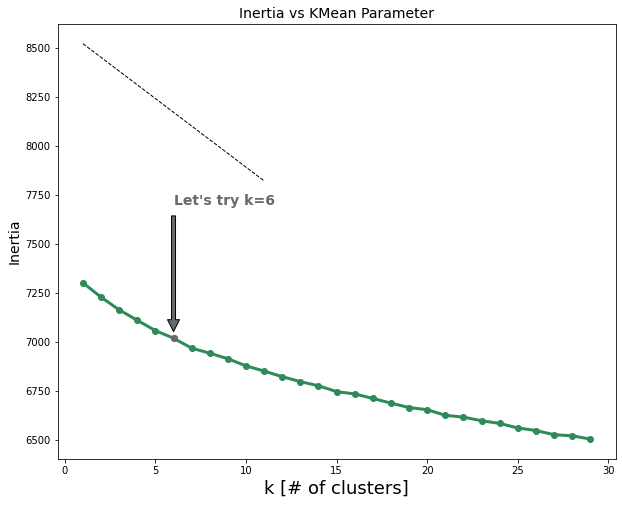

In [142]:
plot_inertia(kRange, inertia_Kmean)
plt.plot([6], [inertia_Kmean[5]], 'o--', color='dimgray', linewidth=3)
plt.plot([1,6,11], [8520, 8170,7820], '--', color='k', linewidth=1)
plt.annotate("Let's try k=6", xy=(6, inertia_Kmean[5]), xytext=(6,7700),
             size=14, weight='bold', color='dimgray',
             arrowprops=dict(facecolor='dimgray', shrink=0.05))

### K-Means with k=6 clusters

It is hard to tell what is the optimal number of clusters from the graph. I tried several number of clusters and finally created 6 clusters with k-Means algorithm

In [143]:
kmeans = KMeans(n_clusters = 6, n_init = 10, n_jobs = -1, random_state=1234)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=1234, tol=0.0001, verbose=0)

In [144]:
common_words=get_common_words(kmeans, 10)
print_common_words(common_words, word_features, vocab_frame)

0 : learn, understand, management, using, works, exam, course, create, team, effectively
1 : data, visualization, using, learn, analysis, create, tableau, charts, analytics, excellent
2 : products, online, amazon, sell, website, create, money, store, make, learn
3 : project, management, agile, risk, learn, using, understand, plan, pmp, exam
4 : business, start, learn, plan, markets, understand, successful, ideas, strategies, create
5 : sales, custom, sell, learn, closing, services, prospecting, markets, lead, understand


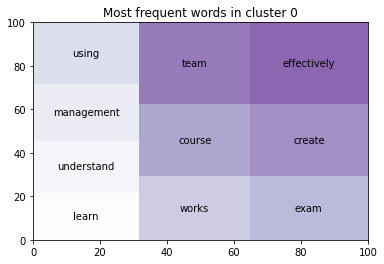

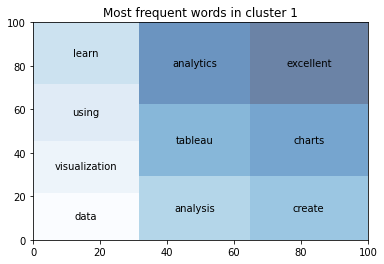

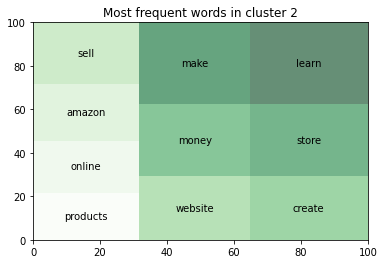

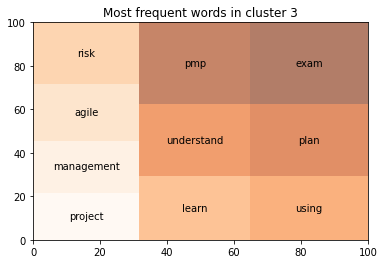

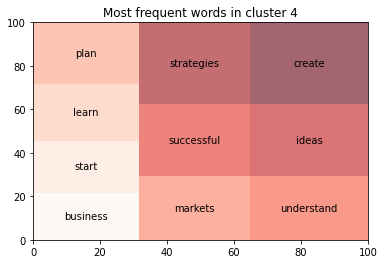

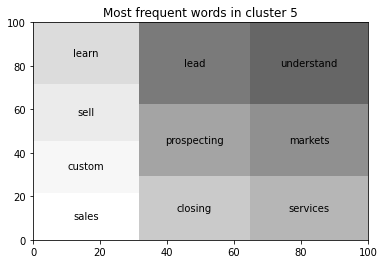

In [145]:
squarify_words(common_words, word_features, vocab_frame)

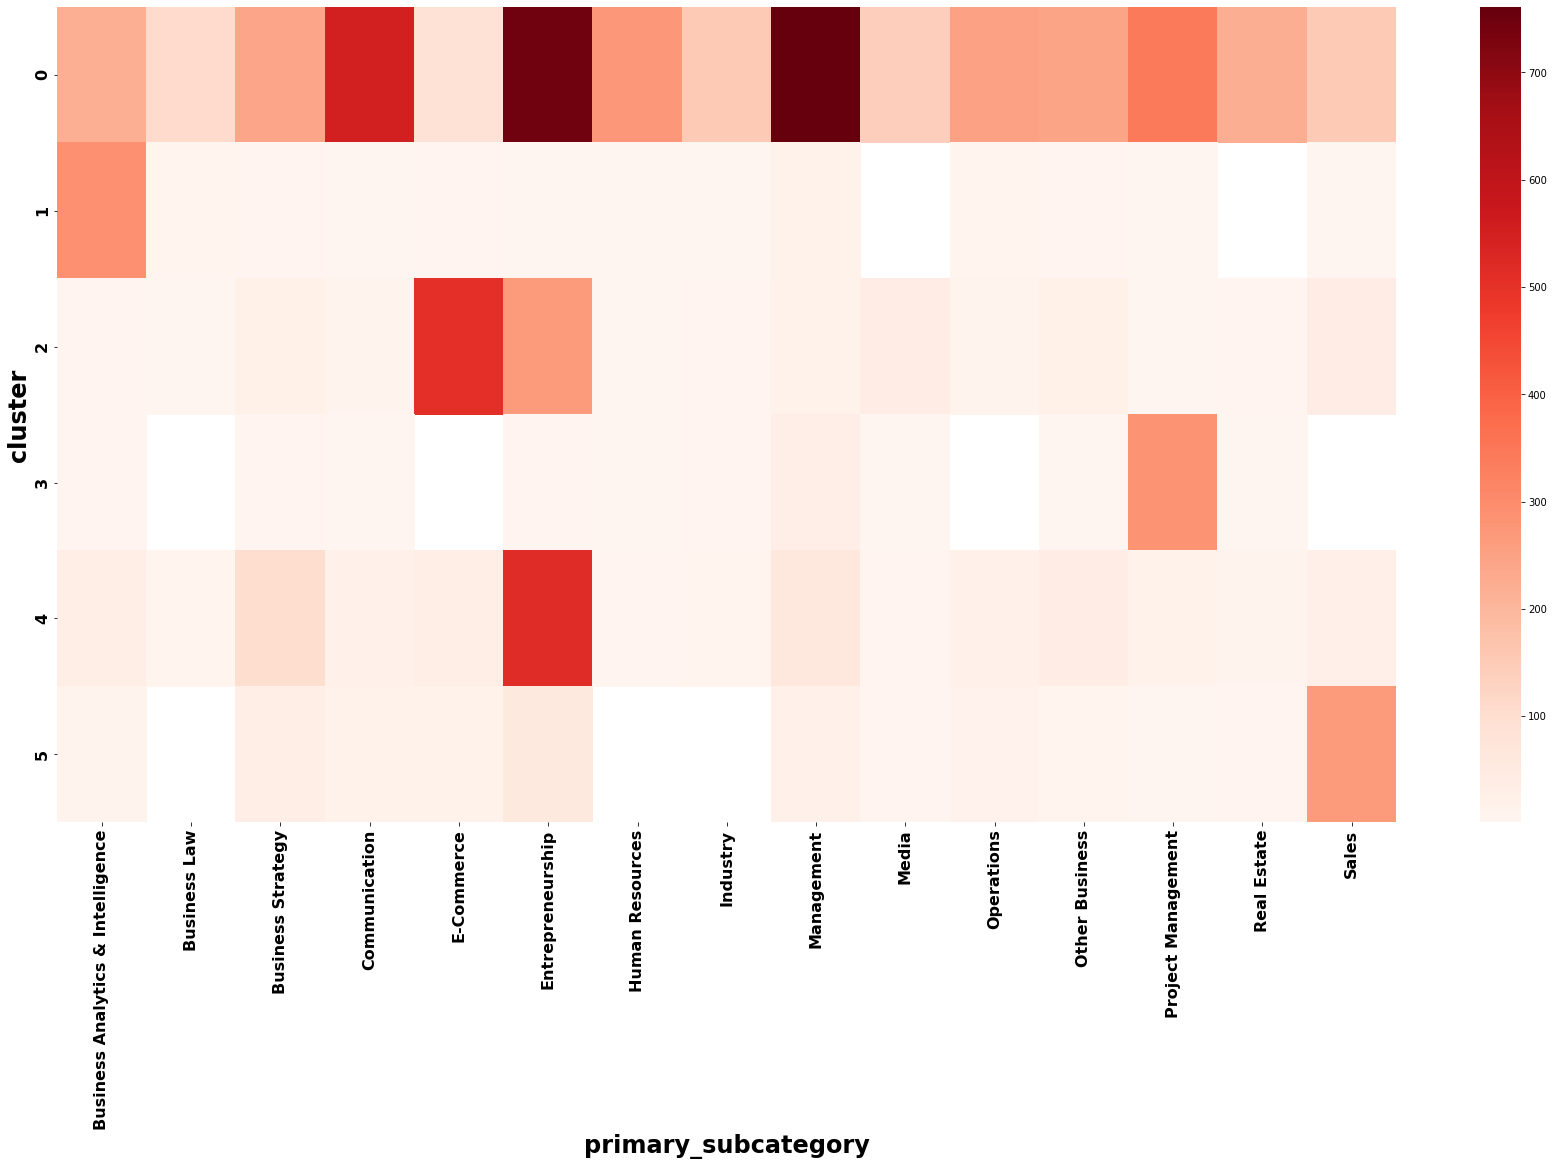

In [146]:
df_courses['cluster']=kmeans.labels_
heatmap_categories_cluster('cluster', df_courses, 'Reds')

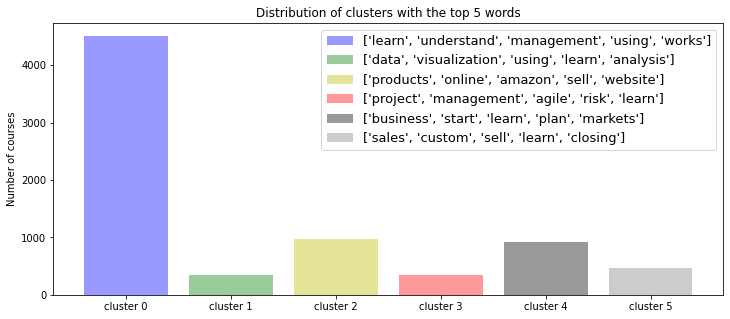

In [147]:
#plot the cluster distribution with the top5 words.More than half of the courses in the last cluster.
plot_common_words(kmeans, 5, word_features, vocab_frame, df_courses, 'cluster')

In [148]:
#print out course titles in each cluster
print_titles_cluster(5, df_courses, 'cluster')

['secret-sauce-of-great-writing'
 'fearless-public-speaker-bootcamp-by-ricky-mendoza'
 'learn-the-truth-about-agile-versus-waterfall' 'learn_power_bi_for_free'
 'how-to-start-a-startup-business']
['how-to-build-an-online-business-a-complete-business-plan'
 'free-amazon-fba-course-for-beginners-2019-private-label'
 'start-a-business-in-5-days-with-shopify-and-productlistgenie'
 'amazon-to-ebay-dropshipping-home-business-starter-course'
 'web-developer-course-on-creating-a-business-website']
['sql-for-real-world-data-analysis' 'tableau-for-beginners-free'
 'power-bi-the-ultimate-orientation' 'unlock-the-story-from-data'
 'machinelearning-analytics']
['agile-project-management-utilizing-microsoft-project-planning-tools'
 'project-management-professional-pmp-intro'
 'enterprise-level-agile-project-management-course-7-of-7'
 'microsoft-project-project-management-scheduling-planning'
 'agile-methodologies-overview']
['unexpected-amazon' 'how-to-start-a-business-with-no-money-y'
 'plan-your-b

### Hierarchical Clustering

In this section I used hierarchical clustering. This method suppose that at the beginning the items have their own clusters.
The algorithm starts to merge the individual clusters on by one. 
I created a dendrogram, which shows the distances between the clusters. I plotted the last 16 merges of the hierarchical clustering algorithm.


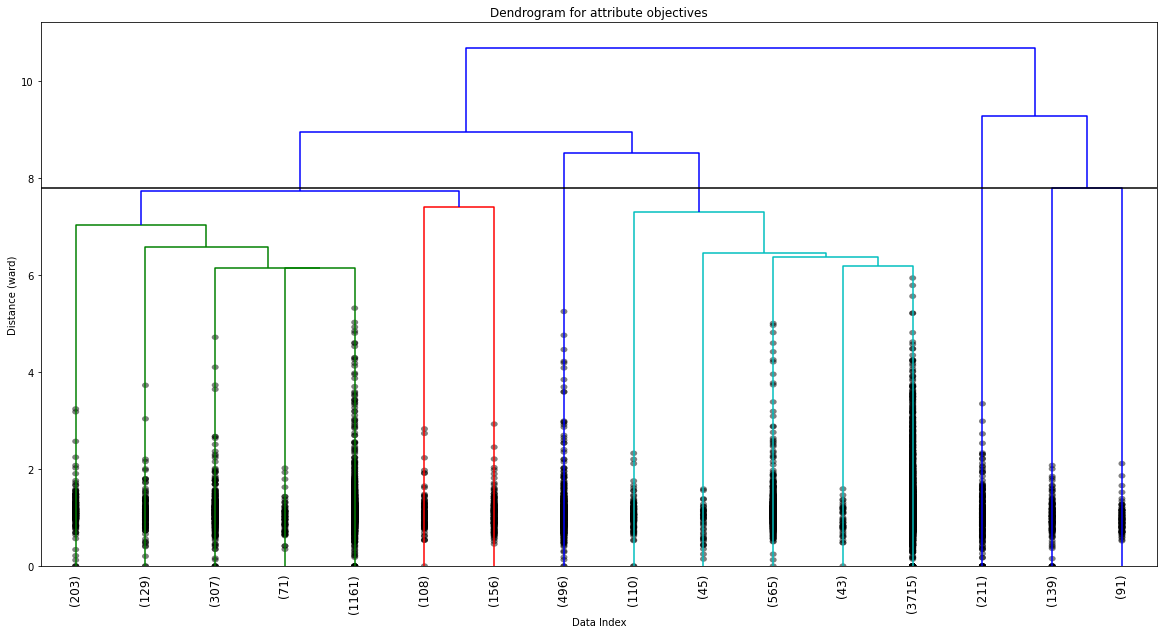

In [149]:
z=get_linkage(X )
plot_dendrogram(z, 16, line_dist=7.8)
#let's cut the dendrogrm at 7.8

In [150]:
#according to the dendrogram, I would cut the graph at 7.8 and get 8 clusters with the following distirbution.
df_courses['cluster_hier']=fcluster(Z=z, t=7.8, criterion='distance')
df_courses['cluster_hier'].value_counts()

3    4478
1    2135
2     496
5     230
4     211
Name: cluster_hier, dtype: int64

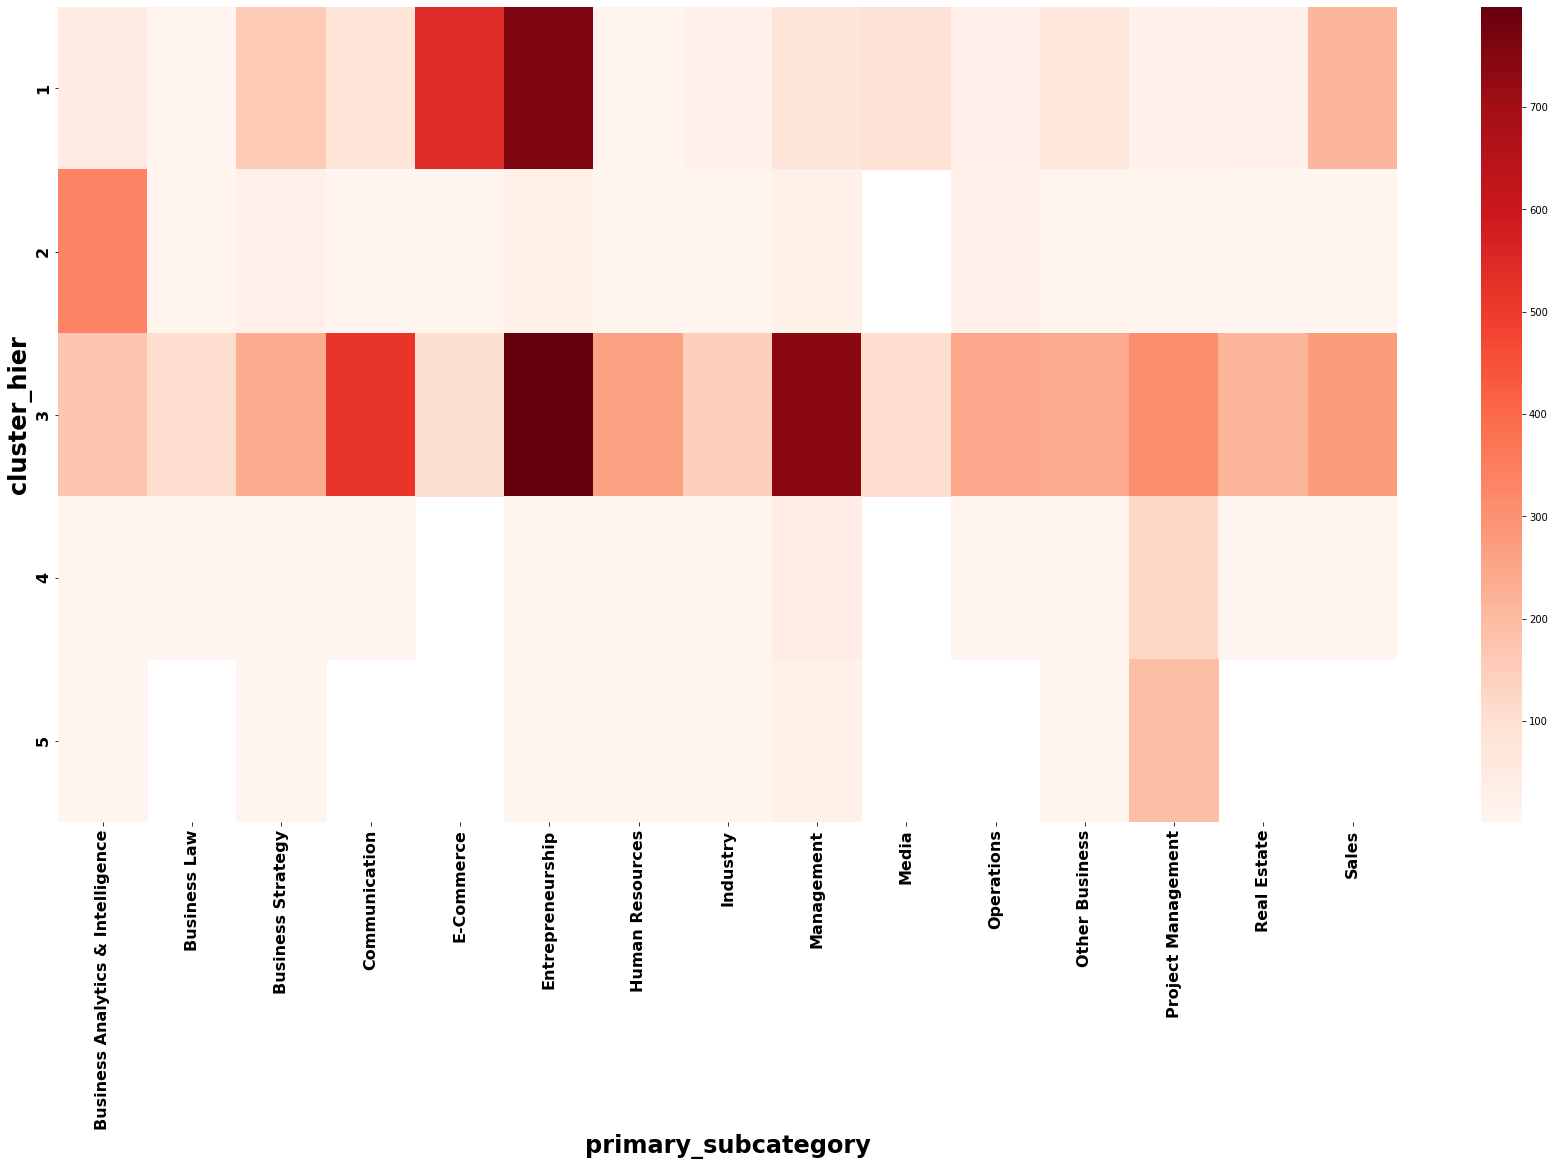

In [151]:
heatmap_categories_cluster('cluster_hier', df_courses, 'Reds' )

The distribution of the clusters through hierarchical clustering is very unproportional.


### PCA for plotting the courses

I will do a simple PCA analysis and keep the first 2 principal components int order to plot the courses in 2D. I will use the results ofthe kmeans clustering (with 6 groups), since the hierarchical clustering resulted in an overproportional group.

The explained variance through the first 2 principal comonent is 0.0271.


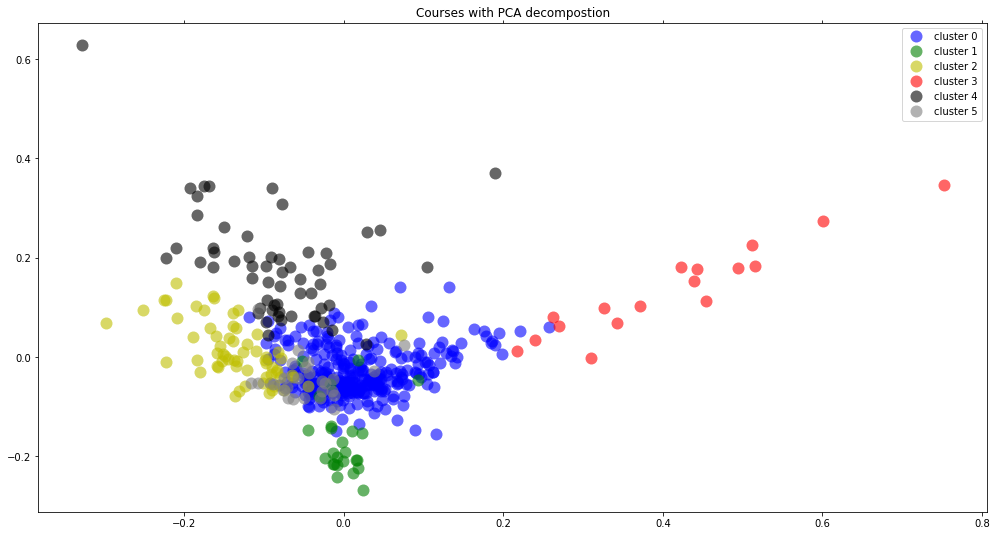

In [152]:
plot_with_pca (X, df_courses['cluster'], 500)

In the 2-D plot, almost all the clusters are well separated from each other. Cluster0 and cluster5 overlap each other - in cluster 5 the majority of the courses can be found.

## Clustering with the description

After building clusters with the objectives attribute, I investigated the course descriptions as the basis of the clustering algorithmns. I executed the same analyses and got better distributed clusters by means of the description feature.  

### K-Means clustering - k=15 clusters

At first I tried to create 15 clusters, similar to the previous clusterings witht the attribute objective. There are clusters with only a few courses, so I tried to optimize the number of clusters to build (k). 

In [153]:
kmeans_descr = KMeans(n_clusters = 15, n_init = 10, n_jobs = -1, random_state=1234)
kmeans_descr.fit(X_descr)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=1234, tol=0.0001, verbose=0)

In [154]:
#top 10 words in each cluster
common_words=get_common_words(kmeans_descr, 10)
print_common_words(common_words, word_features_descr, vocab_frame_descr)

0 : writing, money, makes, get, online, freelancer, book, start, business, sell
1 : project, managed, pmp, risk, schedule, certification, plan, used, nbsp, learning
2 : data, analytics, visuals, tableau, used, analysis, bi, learning, power, statistics
3 : sales, sell, customers, prospecting, closing, learning, business, skills, get, makes
4 : business, start, marketing, plan, success, entrepreneur, learning, get, ideas, helped
5 : learning, used, business, customers, get, understanding, works, needed, helped, nbsp
6 : website, wordpress, creating, site, ecommerce, online, web, used, blog, build
7 : shopify, store, dropshipping, ecommerce, product, online, e-commerce, business, customers, start
8 : nbsp, business, learning, used, get, makes, managed, works, helped, start
9 : agile, scrum, project, team, managed, nbsp, product, certification, developed, mastering
10 : managed, team, organize, leadership, employee, perform, leaders, nbsp, change, learning
11 : estate, real, properties, in

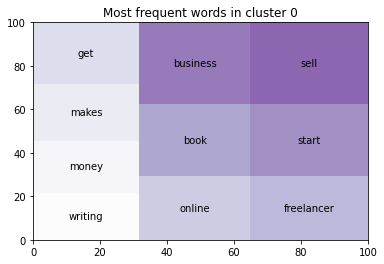

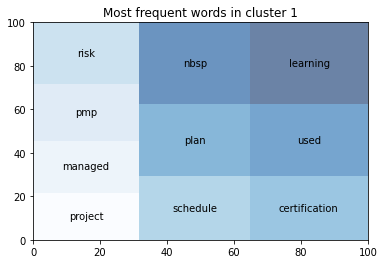

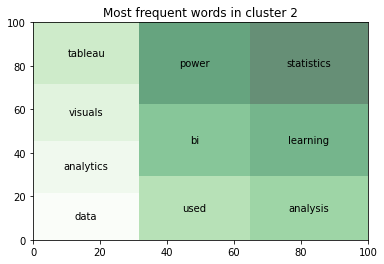

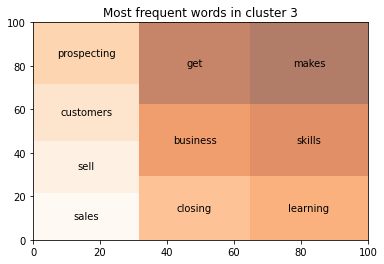

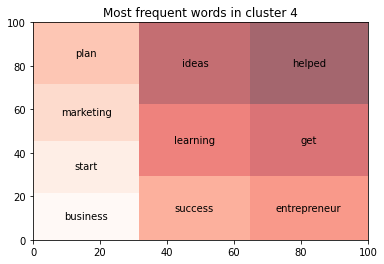

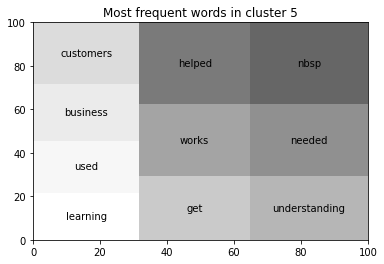

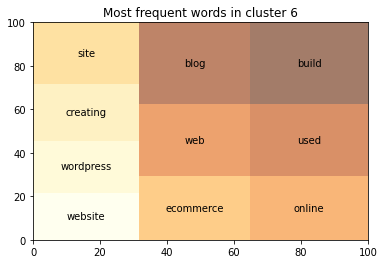

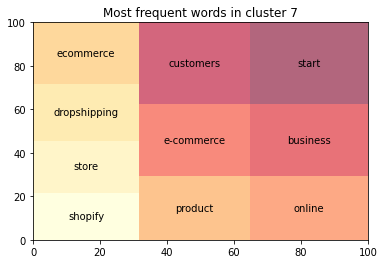

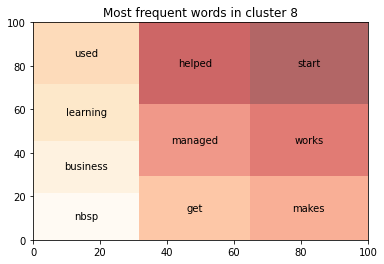

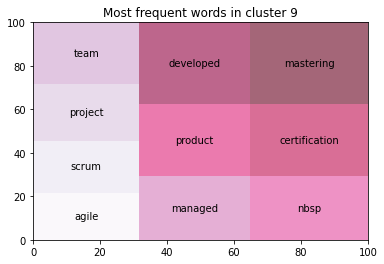

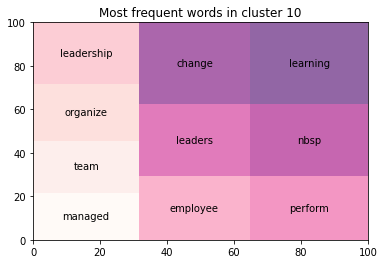

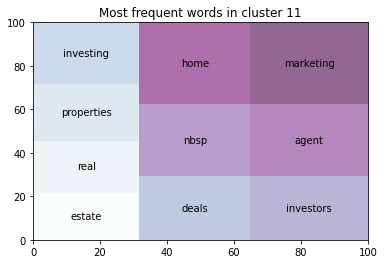

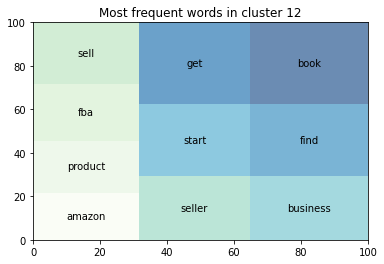

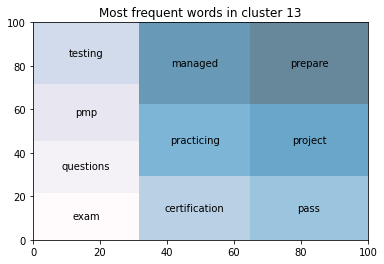

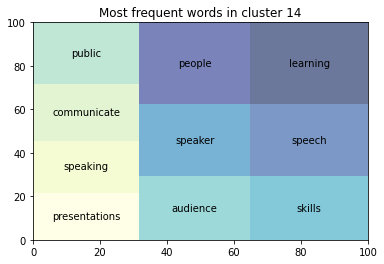

In [155]:
squarify_words(common_words, word_features_descr, vocab_frame_descr)

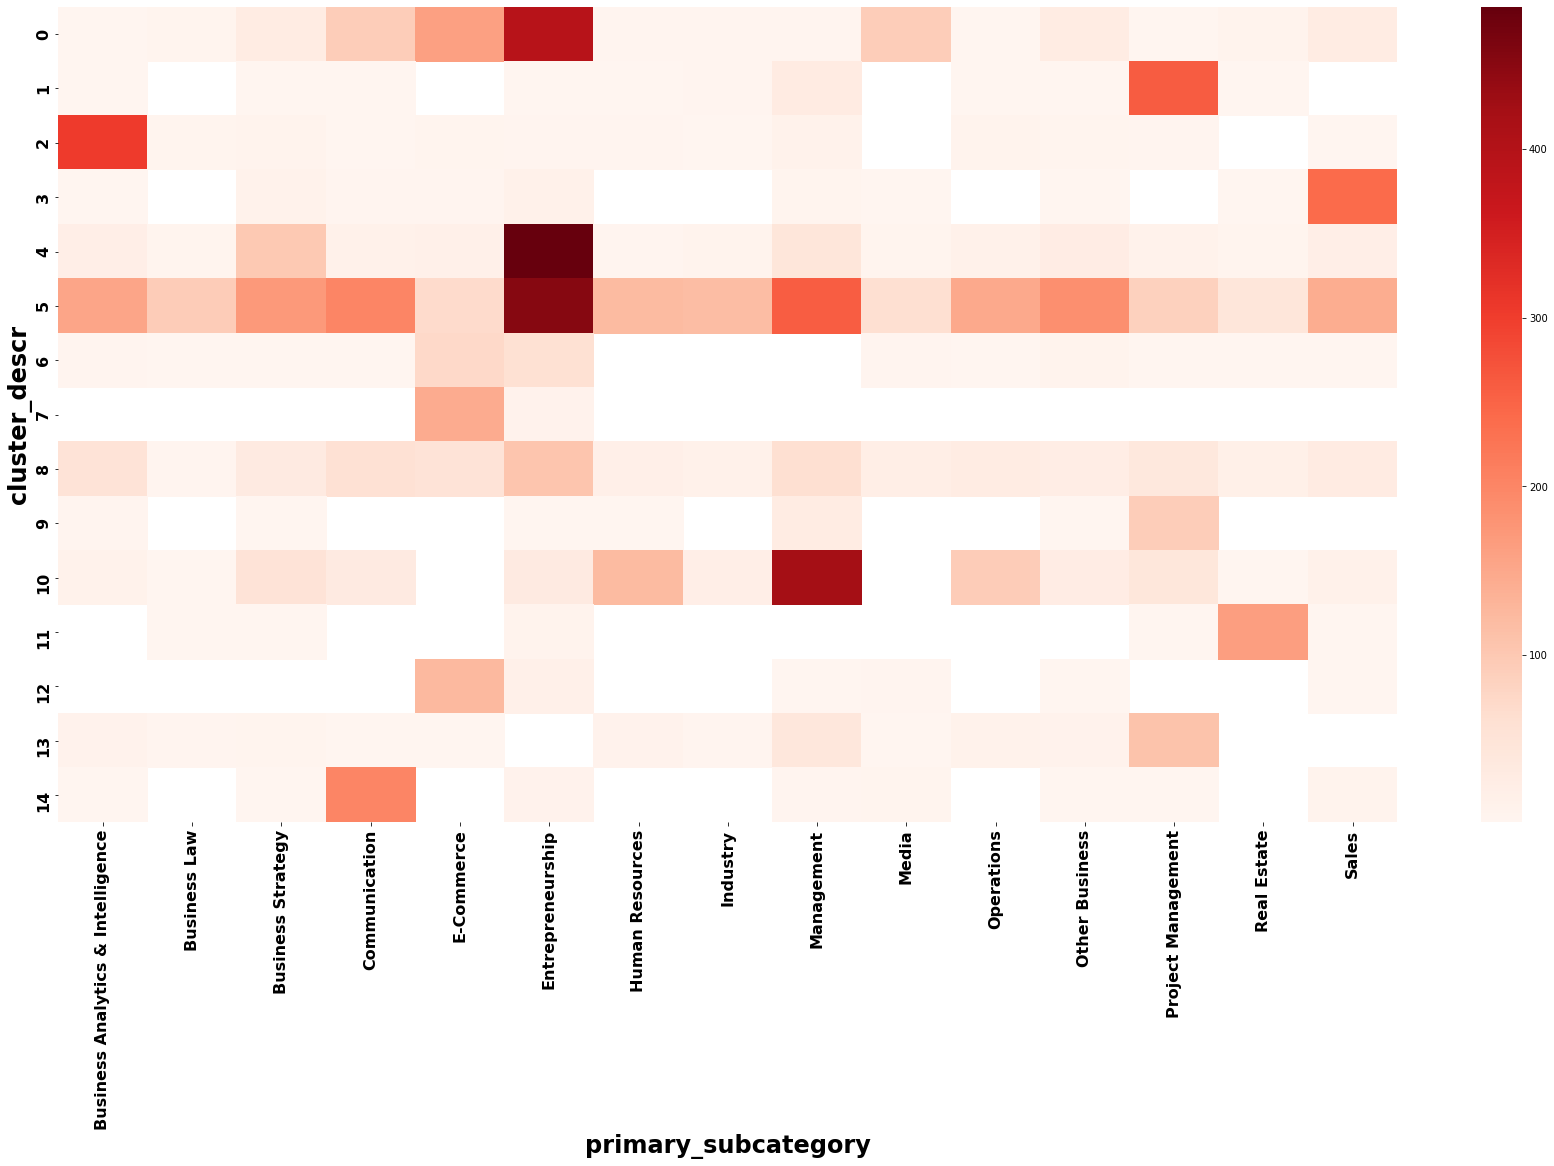

In [156]:
df_courses['cluster_descr']=kmeans_descr.labels_
heatmap_categories_cluster('cluster_descr', df_courses, 'Reds')

In [157]:
#most of the courses are in cluster 4
df_courses['cluster_descr'].value_counts()

5     2318
10     875
0      853
4      777
8      566
2      362
1      305
3      283
14     235
13     207
11     177
6      160
7      155
12     149
9      128
Name: cluster_descr, dtype: int64

### Relationship between number of clusters and inertia by the describtion attribute

In [158]:
kRange = range(1,30)
inertia_Kmean = get_inertia(X_descr, kRange)

Text(9, 7800, "Let's try k=8")

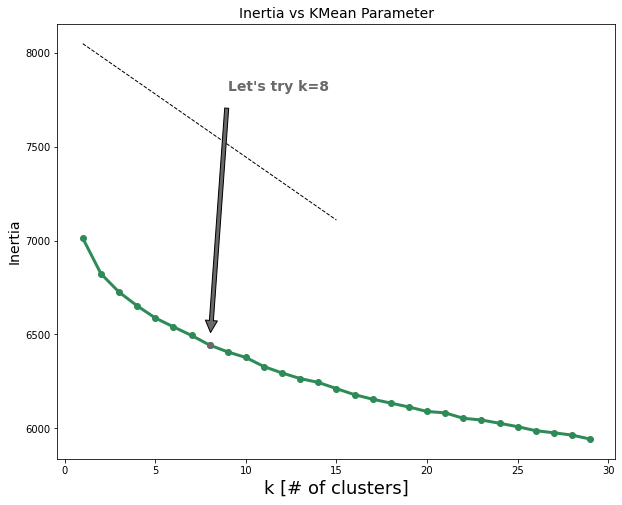

In [159]:
plot_inertia(kRange, inertia_Kmean)
plt.plot([8], [inertia_Kmean[7]], 'o--', color='dimgray', linewidth=3)
plt.plot([1,8,15], [8050, 7580,7110], '--', color='k', linewidth=1)
plt.annotate("Let's try k=8", xy=(8, inertia_Kmean[7]), xytext=(9,7800),
             size=14, weight='bold', color='dimgray',
             arrowprops=dict(facecolor='dimgray', shrink=0.05))

### K-Means with k=8 clusters

In [160]:
kmeans_descr = KMeans(n_clusters = 8, n_init = 10, n_jobs = -1, random_state=123456)
kmeans_descr.fit(X_descr)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=123456, tol=0.0001, verbose=0)

In [161]:
#top 10 words in each cluster
common_words=get_common_words(kmeans_descr, 10)
print_common_words(common_words, word_features_descr, vocab_frame_descr)

0 : managed, learning, used, team, business, understanding, works, skills, nbsp, helped
1 : data, analytics, visuals, tableau, used, analysis, bi, learning, power, statistics
2 : exam, questions, pmp, testing, certification, pass, practicing, project, managed, prepare
3 : nbsp, business, learning, get, used, managed, makes, helped, works, start
4 : get, online, makes, amazon, money, product, start, sell, website, creating
5 : sales, sell, customers, prospecting, closing, learning, business, skills, get, nbsp
6 : project, managed, agile, risk, pmi, certification, pmp, plan, nbsp, learning
7 : business, start, marketing, entrepreneur, success, plan, learning, get, ideas, helped


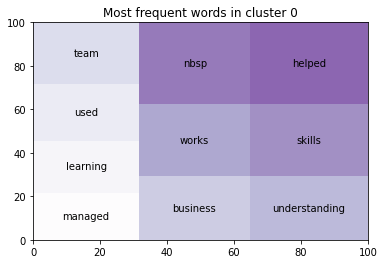

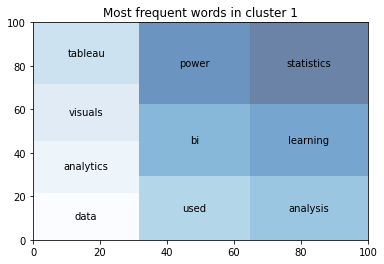

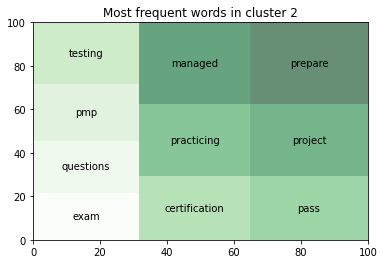

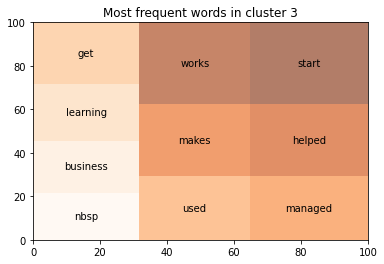

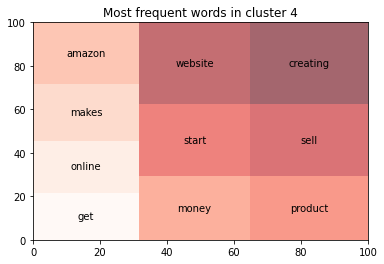

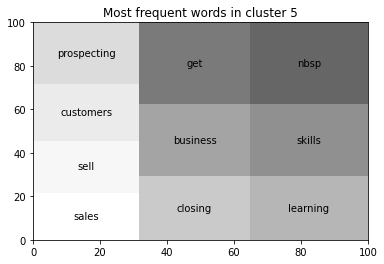

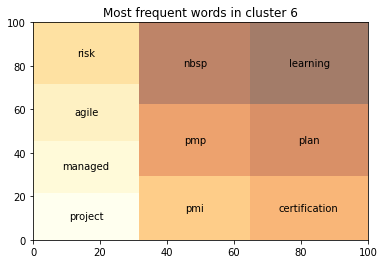

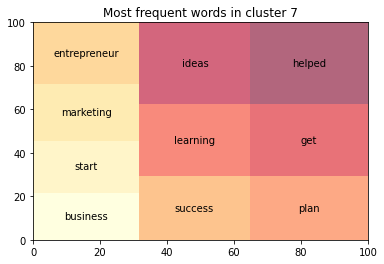

In [162]:
squarify_words(common_words, word_features_descr, vocab_frame_descr)

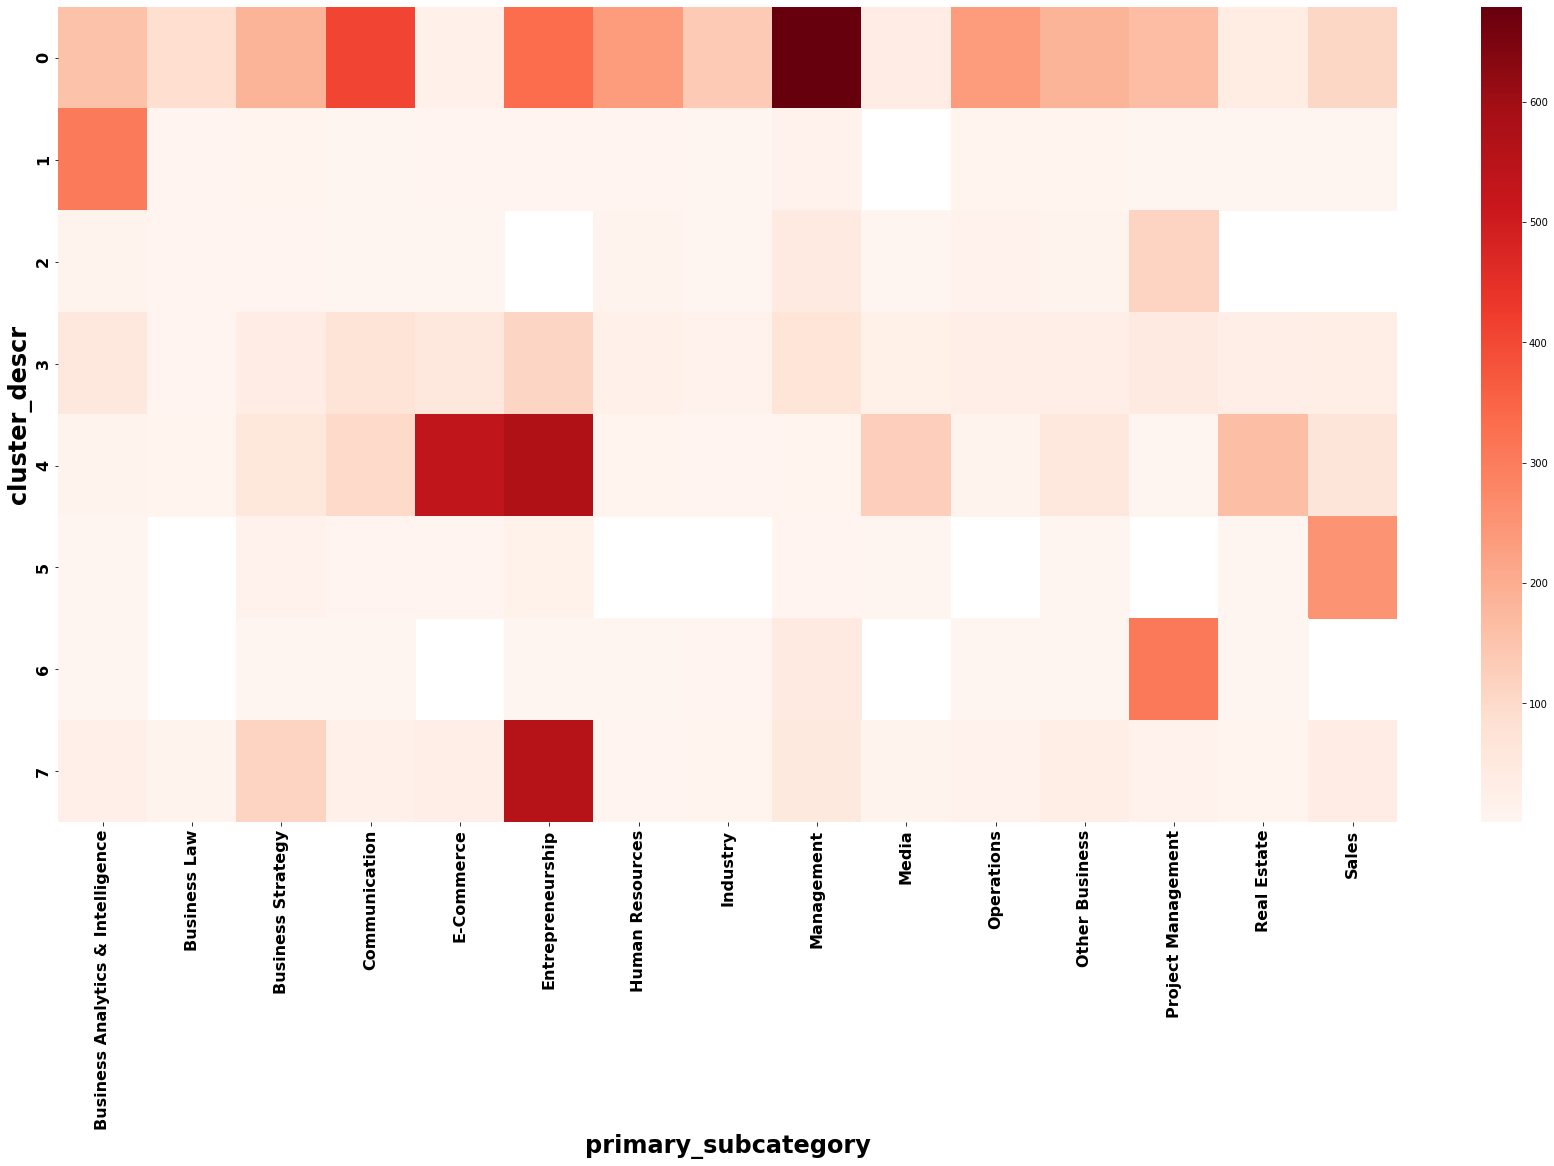

In [163]:
df_courses['cluster_descr']=kmeans_descr.labels_
heatmap_categories_cluster('cluster_descr', df_courses, 'Reds')

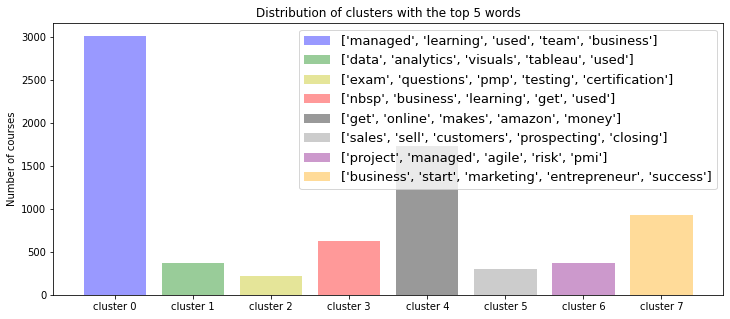

In [164]:
plot_common_words(kmeans_descr, 5, word_features_descr, vocab_frame_descr, df_courses, 'cluster_descr')

In [165]:
print_titles_cluster(3, df_courses, 'cluster_descr')

['secret-sauce-of-great-writing'
 'become-a-business-driven-enterprise-architect'
 'become-a-magento-developer-front-end-cert-subtitled']
['fearless-public-speaker-bootcamp-by-ricky-mendoza'
 'ab-testing-how-to-build-successful-product-experiments'
 'quickbooks-online-vs-quickbooks-desktop']
['learn-the-truth-about-agile-versus-waterfall'
 'agile-project-management-utilizing-microsoft-project-planning-tools'
 'painting-project-manager']
['learn_power_bi_for_free' 'sql-for-real-world-data-analysis'
 'tableau-for-beginners-free']
['how-to-build-an-online-business-a-complete-business-plan'
 'free-amazon-fba-course-for-beginners-2019-private-label'
 'start-a-business-in-5-days-with-shopify-and-productlistgenie']
['how-to-start-a-startup-business'
 '101-crucial-lessons-they-dont-teach-you-in-business-mba-school'
 'plan-your-business']
['salesleadgeneration' 'sales-rockstar-plan'
 'sales-scripts-for-appointment-setting-b2b-quick-start']
['get-your-pgmp-certification-on-your-first-attempt'
 '

### Hierarchical clustering

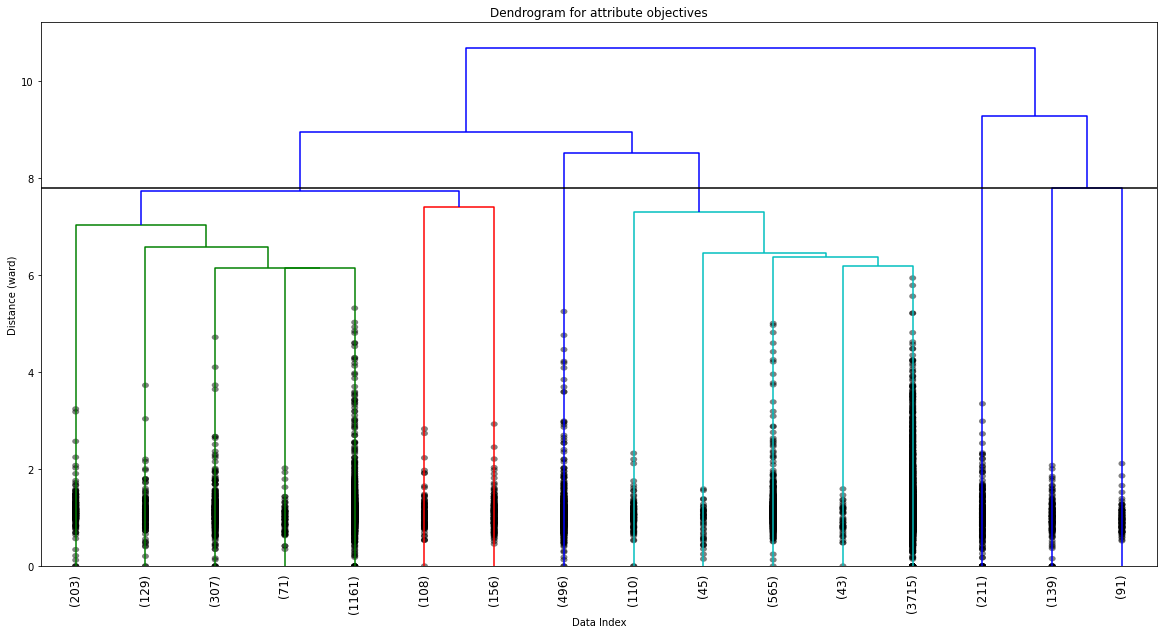

In [166]:
z_descr=get_linkage(X_descr )
plot_dendrogram(z, 16, line_dist=7.8)
#let's cut the dendrogrm at 7.8

In [167]:
#according to the dendrogram, I would cut the graph at 9.6
df_courses['cluster_hier_descr']=fcluster(Z=z_descr, t=9.6, criterion='distance')
df_courses['cluster_hier_descr'].value_counts()

5    3213
4    3060
2     521
1     416
3     340
Name: cluster_hier_descr, dtype: int64

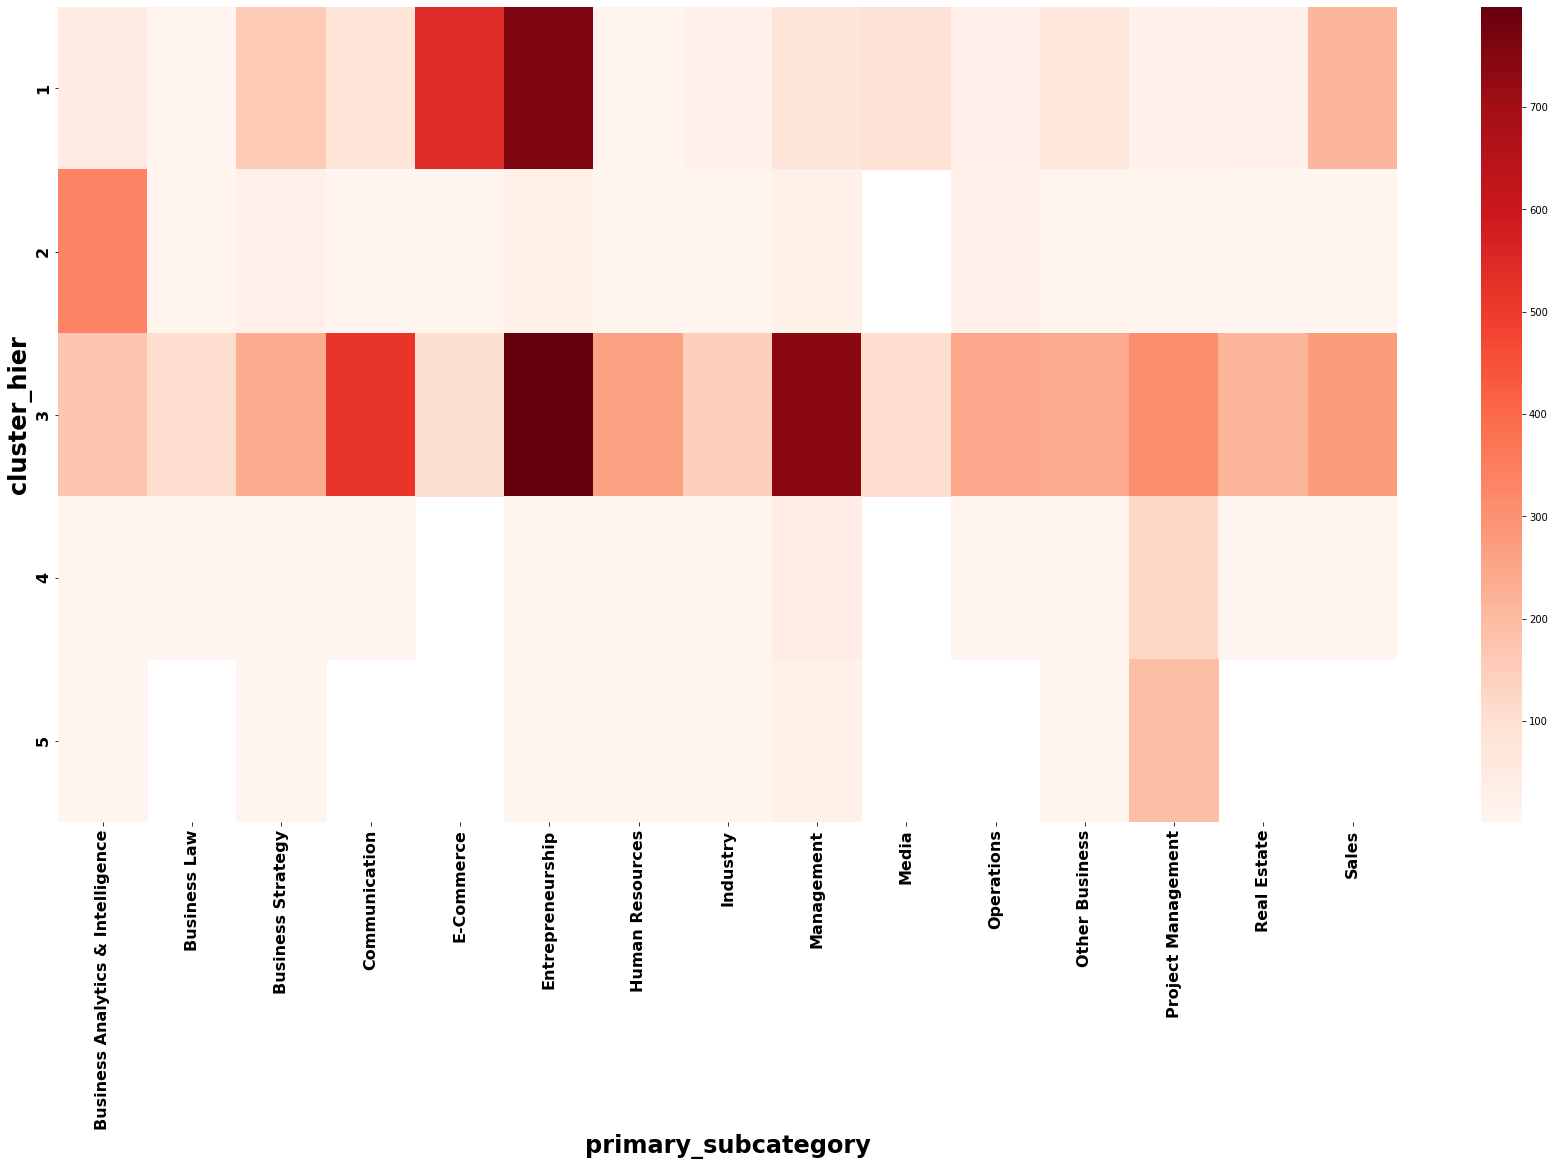

In [168]:
heatmap_categories_cluster('cluster_hier', df_courses, 'Reds' )

The distribution of the clusters through hierarchical clustering is very unproportional with the attribute description as well. In the further analysis I will use results of the k-means clustering with k=8.

### PCA

The explained variance through the first 2 principal comonent is 0.0558.


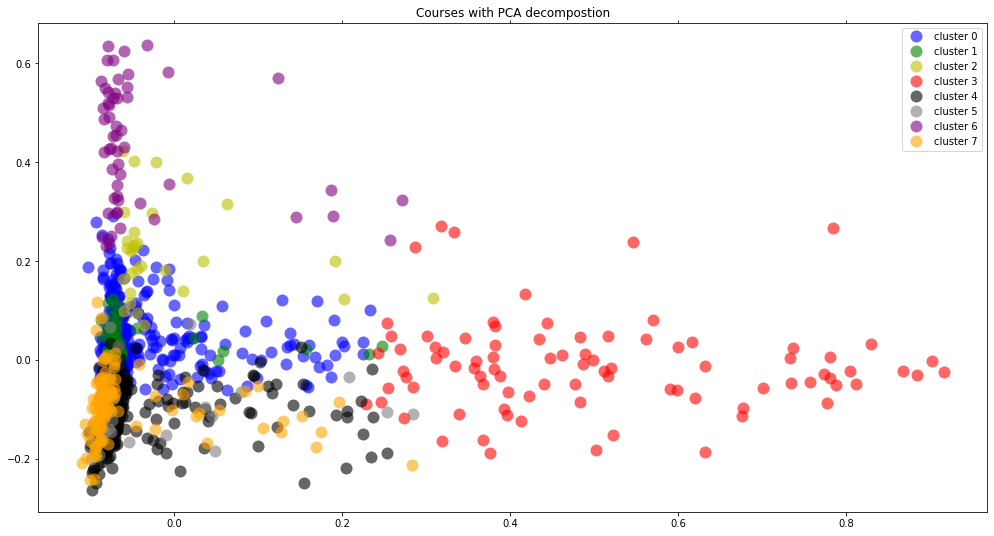

In [169]:
plot_with_pca(X_descr, df_courses['cluster_descr'], 1000)

### Export the clustering algorithm

In [170]:
filename ='kmeans8.sav'
pickle.dump(kmeans_descr, open(filename, 'wb'))

In [171]:
model_kmeans=pickle.load(open('kmeans8.sav', 'rb')) 
model_kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=123456, tol=0.0001, verbose=0)

In [172]:
values=model_kmeans.predict(X_descr)

In [173]:
(values==df_courses['cluster_descr']).sum()

7550

There are clusters, which are close to each other, e.g. cluster 3 is between clusters 0 and 8. Clusters 7, 4 and 1 are also adjacent. It is important to remember that I kept only 2 pricipal components, that explain 4% of the total variance (which is plotted on the graph). In contrast, the clusters are not reduced, they contain all the informations.

## Building the recommender system

For the recommender system I use the course features together with the result of the k-means clustering with k=8. 
I transformed the course dataset into a features matrix by keeping only the relevant features (e.g. no need for course id) For the categorical variables I introduced dummy variables. The clusters were also transformed into dummy variables, since the order of the clusters doesn't have any meaning (cluster 0 is not better or worse than cluster 1).
As the last step of the preparation I normalized the feature matrix, since the features have different scales. 
I used the cosine similarity to compare the courses which each other. 

There are 2 functions, which can be used to recommend courses:
 - Function recommend_for_user recommends courses for the user based on his/her previous courses. This function takes the user as input.
 - Function recommend_courses recommends courses based on another course_id. This function takes the course_id as input and looks for the courses that are similar to the original course.

### Keeping the relevant features and prepare the dataframe

In [ ]:
rel_cols=['avg_rating',  'has_certificate',  'instructional_level', 'num_lectures','num_quizzes',
          'num_practice_tests','is_practice_test_course', 'num_article_assets', 'num_curriculum_items',
          'num_subscribers','num_reviews',  'price', 'primary_subcategory','cluster_descr']
df_rel=df_courses[rel_cols]

In [ ]:
df_rel['has_certificate']=df_rel['has_certificate'].astype(int)
df_rel['cluster_descr']=df_rel['cluster_descr'].astype(str)
dummies=pd.get_dummies(df_rel[['primary_subcategory', 'instructional_level','cluster_descr']], prefix=['subcat', 'level', 'cluster'])
df_rel.drop(columns=['primary_subcategory', 'instructional_level', 'cluster_descr'], inplace=True)
df_rel=pd.concat([df_rel,dummies], axis=1)
df_rel.head()

avg_rating  has_certificate  num_lectures  num_quizzes  num_practice_tests  \
0     4.53965                1           311            8                   0   
1     4.50200                1           151            0                   0   
2     4.48619                1            91            0                   0   
3     4.62332                1            92            7                   0   
4     4.41484                1            89           15                   0   

   is_practice_test_course  num_article_assets  num_curriculum_items  \
0                    False                  27                   319   
1                    False                  10                   151   
2                    False                  26                    91   
3                    False                   2                    99   
4                    False                  33                   104   

   num_subscribers  num_reviews    ...      level_Expert Level  \
0           380584        73048    ...                       0   
1           192581        37914    ...                       0   
2           133919        28313    ...                       0   
3            78429        24114    ...                       0   
4           187207        23214    ...                       0   

   level_Intermediate Level  cluster_0  cluster_1  cluster_2  cluster_3  \
0                         0          0          0          0          1   
1                         0          0          0          0          1   
2                         0          1          0          0          0   
3                         0          0          0          0          1   
4                         0          0          0          1          0   

   cluster_4  cluster_5  cluster_6  cluster_7  
0          0          0          0          0  
1          0          0          0          0  
2          0          0          0          0  
3          0          0          0          0  
4          0          0          0          0  

[5 rows x 39 columns]

In [ ]:
df_norm=normalize_features(df_rel)

In [ ]:
nr_user=df_reviews['user_name'].value_counts()
unique, counts = np.unique(nr_user, return_counts=True)
#dict(zip(unique, counts))
#recommend_for_user(user_name)

In [ ]:
nr_user.sort_values()[:10]

Alina Shapoval              1
Crystal medin               1
Antony Jaramba              1
Kurian Just                 1
Nadine K-digitalMedia       1
Mithun Patlikadan           1
Abhilash Arvind Jangalve    1
Adam Haas                   1
Rini van Rijswijk           1
Pranay Chambhare            1
Name: user_name, dtype: int64

In [ ]:
recommend_for_user('DEEPAK IYER', 5, df_reviews, df_courses, df_norm)

The following courses are recommended after taking the course scala-and-spark-for-big-data-and-machine-learning with the id 977062:
                                     published_title  cosine_similarity
1  microsoft-power-bi-up-running-with-power-bi-de...           0.970756
2                                      mastertableau           0.970164
3                machine-learning-course-with-python           0.938753
4                                          mspowerbi           0.936494
5                                sascompletetutorial           0.935621



In [ ]:
recommend_for_user('Henk Bergsma', 5,df_reviews, df_courses, df_norm)

The following courses are recommended after taking the course machinelearning with the id 950390:
                                     published_title  cosine_similarity
1  python-for-data-science-and-machine-learning-b...           0.996493
2                          the-complete-sql-bootcamp           0.984643
3                                      r-programming           0.974843
4                                          tableau10           0.958937
5                                        datascience           0.954673

The following courses are recommended after taking the course artificial-intelligence-az with the id 1219332:
                                     published_title  cosine_similarity
1                                       deeplearning           0.961594
2                                      python-coding           0.936468
3                          the-complete-sql-bootcamp           0.920872
4                                      r-programming           0.920834